# Final Capstone Project

Idea and data for this project came from the Udacity Self Driving Car Challenge #2: 

https://medium.com/udacity/challenge-2-using-deep-learning-to-predict-steering-angles-f42004a36ff3

Made use of Google Compute Engine Virtual Machine Instance: 

Machine type
n1-highmem-8 (8 vCPUs, 52 GB memory)
CPU platform
Intel Haswell
GPUs
1 x NVIDIA Tesla K80

Model visualization on unseen test image set:
https://www.youtube.com/watch?v=8Y4VdrsGvrs

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

# for reproducibility

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import math
import keras
#import skimage
#from skimage import data, color
#from skimage.transform import rescale, resize, downscale_local_mean
#from PIL import Image, ImageEnhance
from scipy import ndimage
from scipy import stats
from sklearn.model_selection import train_test_split

import tensorflow as tf

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import load_model
import h5py

# Import the backend
from keras import backend as K

Using TensorFlow backend.


In [2]:
#Tell tensorflow to use the GPU
#Install tensorflow-gpu
num_cores = 8

#Tell code to run with GPU
GPU = True
CPU = False

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

(480, 640, 3)


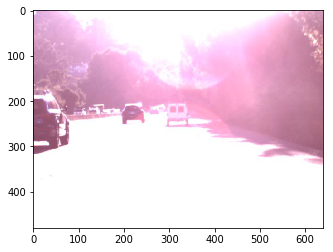

In [3]:
#Let's get an idea of the data we're dealing with. Load an image and get its shape.
path = r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory\center\1479424215880976321.jpg'
im = skimage.io.imread(path)
print(im.shape)
plt.imshow(im)
plt.show()

To begin, I am only going to use images from the center camera. Eventually I will add images from the left and right cameras in order to add more training data to the network.

I will also not alter the images in this first pass. May eventually need to crop images (such that only road is showing in most images), or add a "jitter" to artificially create more training data. May also need to scale down size of image for performance purposes in training the Neural Net.

Have realized that the timestamps on the images do not exaclty align with timestamps in the steering angle file. Fortunately the Dockerfile I used (courtesy of rwightman: https://github.com/rwightman/udacity-driving-reader) created an interpolated steering angle that aligns with the image timestamps.

In [14]:
c_steer_train = pd.read_csv(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory\interpolated.csv')
c_steer_train = c_steer_train[c_steer_train['frame_id'] == 'center_camera'][['timestamp', 'filename', 'angle']]
c_steer_train.reset_index(inplace = True)
c_steer_train.head()

index            timestamp                        filename     angle
0  67588  1479424215880976321  center/1479424215880976321.jpg  0.001039
1  67589  1479424215930775951  center/1479424215930775951.jpg  0.003491
2  67590  1479424215980916687  center/1479424215980916687.jpg  0.003491
3  67591  1479424216030737492  center/1479424216030737492.jpg  0.005236
4  67592  1479424216080827865  center/1479424216080827865.jpg  0.006234

In [15]:
#Validation / holdout set should be end sequences of each of the 5 separate trips in the training set. Using random images from 
#each trip would result in model having "seen" very similar images between the fit and predict steps

#From the .yaml files: 
#Trip 1: start: 1479424214743813120; end: 1479424435955945984
#Trip 2: start: 1479424438022508032; end: 1479425229044132096
#Trip 3: start: 1479425728713969920; end: 1479425828505740800
#Trip 4: start: 1479425832947890944; end: 1479426045822525952
#Trip 5: start: 1479426201119651072; end: 1479426572360982784

#Trip 6: (test)

def trip_no(timestamp):
    if timestamp >= 1479424214743813120 and timestamp <= 1479424435955945984:
        return 1
    elif timestamp >= 1479424438022508032 and timestamp <= 1479425229044132096:
        return 2
    elif timestamp >= 1479425728713969920 and timestamp <= 1479425828505740800:
        return 3
    elif timestamp >= 1479425832947890944 and timestamp <= 1479426045822525952:
        return 4
    elif timestamp >= 1479426201119651072 and timestamp <= 1479426572360982784:
        return 5
    else: 
        return 6
    
c_steer_train['trip'] = c_steer_train['timestamp'].apply(trip_no)

In [16]:
#Remove trip 6 (the test set) from the c_steer_train DF
c_steer_train = c_steer_train[c_steer_train['trip'] != 6]
c_steer_train.reset_index(inplace = True)

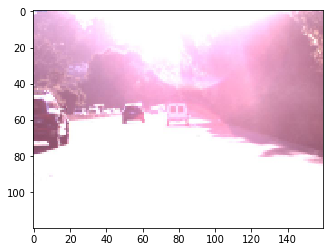

(120, 160, 3)


In [7]:
#Will need to resize data now due to memory constraints. Test to make sure the resized image looks correct.
image = skimage.io.imread(path)
image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
plt.imshow(image_resized)
plt.show()
print(image_resized.shape)

Image looks ~identical to non-scaled version. 

In [17]:
#Test set evaluation file downloaded from https://github.com/udacity/self-driving-car/blob/master/challenges/challenge-2/CH2_final_evaluation.csv
c_steer_test = pd.read_csv(r'C:\Users\ryan13829\Desktop\Thinkful\CH2_final_evaluation.csv')
test_root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\center')

Instead of evaluating model performance only on the test set, I am going to create a validation set as well. The validation set will take the last 20% of frames from each of the 5 training driving trips. Normally, we would take a random 20%, but in this case we don't want to, since the model could unfairly benefit from seeing very similar images before/after validation images were taken. This will also require shrinking the training set. 

In [18]:
#Create 20% validation set by removing the samples from c_steer_train

train_df = pd.DataFrame()
val_df = pd.DataFrame()

for trip in range(5):
    split = math.floor(len(c_steer_train[c_steer_train['trip'] == trip+1]) * 0.8)
    train_df = train_df.append(c_steer_train[c_steer_train['trip'] == trip+1][: split])
    val_df = val_df.append(c_steer_train[c_steer_train['trip'] == trip+1][split :])
    
c_steer_train = train_df
c_steer_val = val_df


#Drop and reset indices
c_steer_train.drop('level_0', axis = 1, inplace = True)
c_steer_val.drop('level_0', axis = 1, inplace = True)

c_steer_train.reset_index(inplace = True)
c_steer_val.reset_index(inplace = True)

In [10]:
#Instantiate the array we're going to use to store the center images. 
shape = (len(c_steer_train), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
c_img_array = np.zeros(shape = shape)
c_img_array.shape

(27044, 120, 160, 3)

In [192]:
#Instantiate the array we're going to use to store the center images. 
shape = (len(c_steer_train), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
c_img_array = np.zeros(shape = shape)
c_img_array.shape

#Set root directory to location of output files. Use os.path.normpath to handle '/' vs '\'
root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory')

#Load resized, normalized training image files into array
for i in range(len(c_steer_train)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_train['filename'][i]))
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    c_img_array[i] = image_resized 

In [193]:
#Now do the same for validation

shape = (len(c_steer_val), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
val_img_array = np.zeros(shape = shape)
val_img_array.shape

#Load resized, normalized training image files into array
for i in range(len(c_steer_val)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_val['filename'][i]))
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    val_img_array[i] = image_resized 

In [194]:
#Load resized, normalized test image files into array
shape = (len(c_steer_test), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
test_img_array = np.zeros(shape = shape)

for i in range(len(c_steer_test)):
    image = skimage.io.imread(test_root + '\\' + str(c_steer_test['frame_id'][i]) + '.jpg')
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    #Normalize the RGB pizel values
    test_img_array[i] = image_resized

# Get a sense of the steering angle distribution in the training data

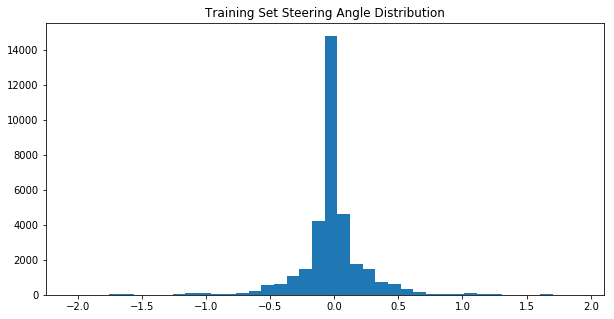

In [15]:
plt.figure(figsize = (10,5))
plt.title('Training Set Steering Angle Distribution')
plt.hist(c_steer_train['angle'], bins = 40)
plt.show()

Perhaps as expected, the steering angle is usually close to 0 - by a large margin - with left and right angles approximately balanced.

# Model 1

In [195]:
#Specify inputs for model constructor below

(x_train, y_train) = (c_img_array, c_steer_train['angle'])
(x_val, y_val) = (val_img_array, c_steer_val['angle'])
(x_test, y_test) = (test_img_array, c_steer_test['steering_angle'])

In [203]:
#Define a model function so we don't have to call this long piece of code every time 

def model_struct_1(x_train, y_train, x_test, y_test, batch, nb_epochs):
    
    img_rows, img_cols = image_resized.shape[0], image_resized.shape[1]

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
        input_shape = (3, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 3)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # Building the Model
    model = Sequential()
    # First convolutional layer, note the specification of shape
    model.add(Conv2D(32, kernel_size=(3, 3),
                     #strides = (3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    #####
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['mae'])

    model.fit(x_train, y_train,
              batch_size=batch,
              epochs=nb_epochs,
              verbose=1,
              shuffle = True,
              validation_data=(x_test, y_test))
    
    return model

In [204]:
m1a = model_struct_1(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 5)

Train on 27044 samples, validate on 6764 samples
Epoch 1/5
27044/27044 [==============================] - 76s - loss: 0.8500 - mean_absolute_error: 0.2440 - val_loss: 0.0294 - val_mean_absolute_error: 0.1152
Epoch 2/5
27044/27044 [==============================] - 75s - loss: 0.0546 - mean_absolute_error: 0.1312 - val_loss: 0.0186 - val_mean_absolute_error: 0.0982
Epoch 3/5
27044/27044 [==============================] - 75s - loss: 0.0393 - mean_absolute_error: 0.1099 - val_loss: 0.0226 - val_mean_absolute_error: 0.1100
Epoch 4/5
27044/27044 [==============================] - 75s - loss: 0.0313 - mean_absolute_error: 0.0980 - val_loss: 0.0150 - val_mean_absolute_error: 0.0826
Epoch 5/5
27044/27044 [==============================] - 75s - loss: 0.0269 - mean_absolute_error: 0.0916 - val_loss: 0.0176 - val_mean_absolute_error: 0.0921


Let's store the model predictions after 5 epochs, and then compare to the model predictions after 5 additional epochs.

In [205]:
z = m1a.predict(x_test)
preds_df = pd.DataFrame(z)
preds_df.to_csv(r'C:\Users\ryan13829\Desktop\Thinkful\preds_m1.csv')

In [206]:
#Now re-train for 5 additional epochs to see if additional training improves model accuracy.
m1a.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          shuffle = True,
          validation_data=(x_val, y_val))

Train on 27044 samples, validate on 6764 samples
Epoch 1/5
27044/27044 [==============================] - 87s - loss: 0.0234 - mean_absolute_error: 0.0856 - val_loss: 0.0173 - val_mean_absolute_error: 0.0897
Epoch 2/5
27044/27044 [==============================] - 87s - loss: 0.0205 - mean_absolute_error: 0.0808 - val_loss: 0.0148 - val_mean_absolute_error: 0.0814
Epoch 3/5
27044/27044 [==============================] - 87s - loss: 0.0189 - mean_absolute_error: 0.0774 - val_loss: 0.0166 - val_mean_absolute_error: 0.0856
Epoch 4/5
27044/27044 [==============================] - 87s - loss: 0.0174 - mean_absolute_error: 0.0747 - val_loss: 0.0115 - val_mean_absolute_error: 0.0711
Epoch 5/5
27044/27044 [==============================] - 87s - loss: 0.0151 - mean_absolute_error: 0.0700 - val_loss: 0.0131 - val_mean_absolute_error: 0.0753


In [208]:
#Store predictions after 10 epochs
z2 = m1a.predict(x_test)
preds_df = pd.DataFrame(z2)
preds_df.to_csv(r'C:\Users\ryan13829\Desktop\Thinkful\preds_m2.csv')

In [3]:
#Define Evaluation metric (RMSE - root mean square error)

def rmse(preds, y_test):
    preds = preds.reshape(len(preds), )
    sq_residuals = (np.sum((preds - y_test)**2))
    rmse = round(math.sqrt(sq_residuals / len(preds)), 5)
    print("Root Mean Squared Error:", rmse)

In [210]:
#Compare RMSE of first model between 5 and 10 epochs of training - does additional training help with the current model?

rmse(z, y_test)
rmse(z2, y_test)

Root Mean Squared Error: 0.20096
Root Mean Squared Error: 0.1921


In [212]:
#Let's see how we did on the validation set...

val_pred = m1a.predict(x_val)
rmse(val_pred, y_val)

Root Mean Squared Error: 0.11442


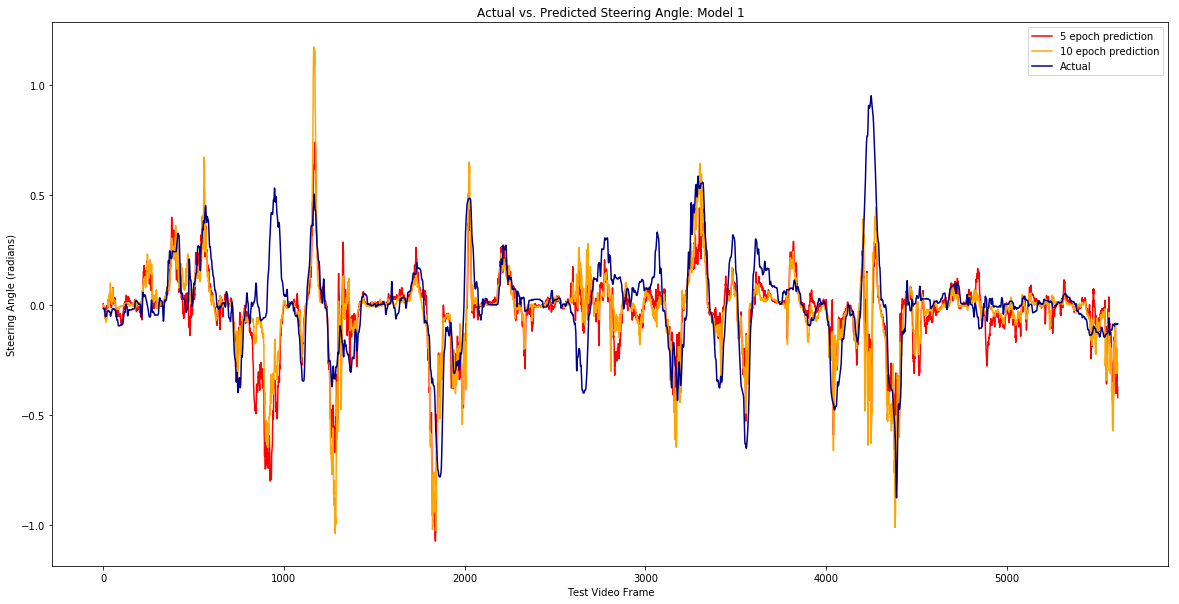

In [211]:
#Produce visualizations for the first two sets of predictions on the test set

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 1')
plt.plot(z, label = '5 epoch prediction', c = 'red')
plt.plot(z2, label = '10 epoch prediction', c = 'orange')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

There is no significant performance difference between the model predictions after 5 and 10 epochs, and both were quite bad.

Both sets of model predictions suffered when large magnitude turns were made. The models also completely miss the beginning of a turn in frames ~900-1000 (and turns in the opposite direction).

Let's further process the input/training data.

# Model 2
Enhancements: Cropped Images.


My first idea to improve the model is to crop input images to reduce "noise," or any image data above the road (trees, sky, sun, etc). Visual inspection of the image files suggests we can remove the top half of pixel rows in each image.

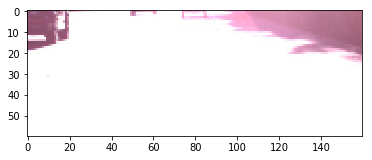

(60, 160, 3)


In [229]:
path = r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory\center\1479424215880976321.jpg'
image = skimage.io.imread(path)
#Image is 480 pixels tall, so use 240
image = image[240:]
image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
plt.imshow(image_resized)
plt.show()
print(image_resized.shape)

So now we have a 4x scaled down version of an image where we removed the top half of pixel rows. Let's build out the rest of the dataset and train a new model to see how it affects performance.

In [176]:
#Crop the train images

shape = (len(c_steer_train), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
c_img_array = np.zeros(shape = shape)
c_img_array.shape

#Set root directory to location of output files. Use os.path.normpath to handle '/' vs '\'
root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory')

#Load resized, normalized training image files into array
for i in range(len(c_steer_train)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_train['filename'][i]))
    #Image is 480 pixels tall, so use 240
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    c_img_array[i] = image_resized 

In [177]:
#Crop the validation images

shape = (len(c_steer_val), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
val_img_array = np.zeros(shape = shape)
val_img_array.shape

#Load resized, normalized training image files into array
for i in range(len(c_steer_val)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_val['filename'][i]))
    #Image is 480 pixels tall, so use 240
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    val_img_array[i] = image_resized 

In [52]:
#Crop the test images

#Load resized, normalized test image files into array
shape = (len(c_steer_test), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
test_img_array = np.zeros(shape = shape)

for i in range(len(c_steer_test)):
    image = skimage.io.imread(test_root + '\\' + str(c_steer_test['frame_id'][i]) + '.jpg')
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    #Normalize the RGB pizel values
    test_img_array[i] = image_resized

In [178]:
#Specify inputs for model constructor below

(x_train, y_train) = (c_img_array, c_steer_train['angle'])
(x_val, y_val) = (val_img_array, c_steer_val['angle'])
(x_test, y_test) = (test_img_array, c_steer_test['steering_angle'])

In [181]:
m2a = model_struct_1(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 5)

Train on 27044 samples, validate on 6764 samples
Epoch 1/5
27044/27044 [==============================] - 37s - loss: 0.7134 - mean_absolute_error: 0.2174 - val_loss: 0.0293 - val_mean_absolute_error: 0.1125
Epoch 2/5
27044/27044 [==============================] - 35s - loss: 0.0627 - mean_absolute_error: 0.1374 - val_loss: 0.0125 - val_mean_absolute_error: 0.0780
Epoch 3/5
27044/27044 [==============================] - 35s - loss: 0.0499 - mean_absolute_error: 0.1182 - val_loss: 0.0125 - val_mean_absolute_error: 0.0770
Epoch 4/5
27044/27044 [==============================] - 35s - loss: 0.0404 - mean_absolute_error: 0.1068 - val_loss: 0.0121 - val_mean_absolute_error: 0.0739
Epoch 5/5
27044/27044 [==============================] - 35s - loss: 0.0335 - mean_absolute_error: 0.0985 - val_loss: 0.0108 - val_mean_absolute_error: 0.0696


In [186]:
#Score on the validation and test data

val_pred = m2a.predict(x_val)
test_pred = m2a.predict(x_test)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

Root Mean Squared Error: 0.10394
Root Mean Squared Error: 0.14832


Our RMSE scores both improved from the first iteration of this model, but still differ fairly significantly. Ideally we would like them to be approximately the same value.

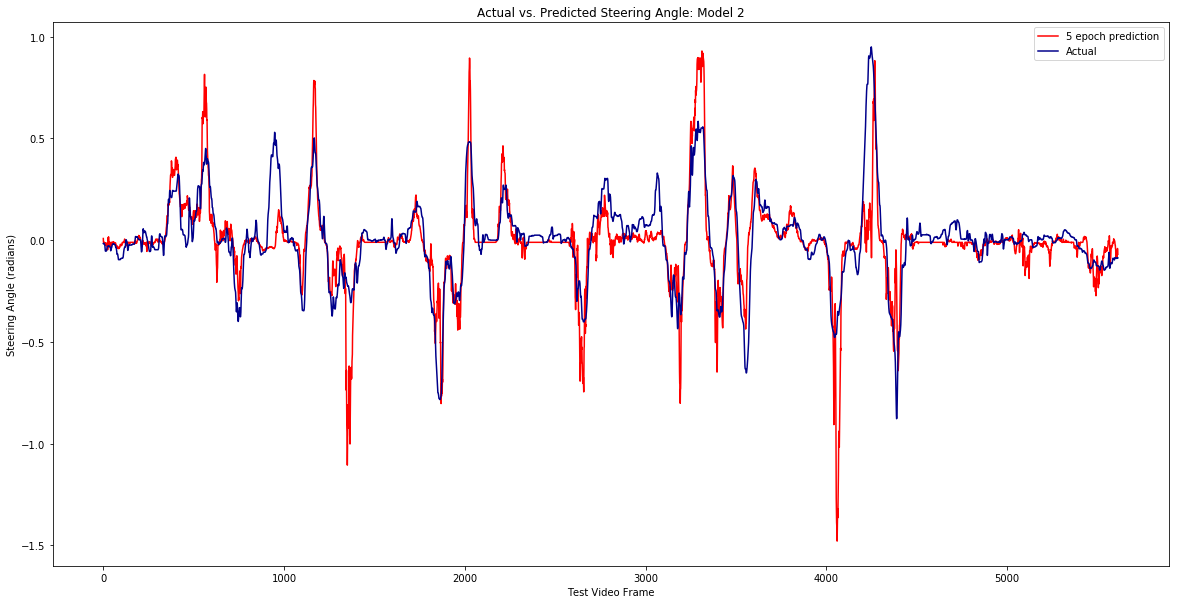

In [216]:
#Produce visualizations 

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 2')
plt.plot(test_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

Clearly, removing the "noise" from the top half of the image helped, but we still have a lot of room for further improvement.

Now let's take a look at frames where predicted values deviated significantly from actual and see if we can get some more ideas for how to further improve our model. All prediction sets so far have completely missed the turn that takes place from frames ~900 - 1000. Let's see if we can figure out why.

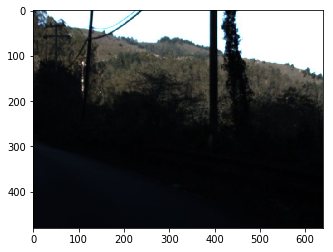

In [221]:
#Show original image first so that we have all contextual information.
image = skimage.io.imread(test_root + '\\' + str(c_steer_test['frame_id'][950]) + '.jpg')
plt.imshow(image)
plt.show()

Turns out the model had a hard time seeing the road in this instance. It's easy to see why, it's way too dark! Let's brighten the image up to see if that will help us detect the road.

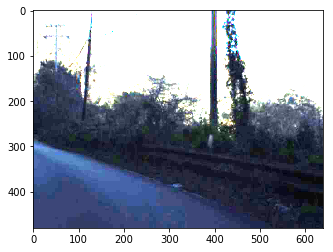

In [222]:
im = Image.open(test_root + '\\' + str(c_steer_test['frame_id'][950]) + '.jpg')
im = ImageEnhance.Brightness(im)
im = im.enhance(10)
plt.imshow(im)
plt.show()

Much better! This PIL function is really cool, but it converts the input to a PIL.JpegImagePlugin.JpegImageFile (not usable as an array). Define a function to convert it back to an array after we have brightened it.

# Model 3 (Part 1: Color Images)
Enhancements: Cropped Images, Brightened Dark Images, Color vs. Grayscale, and added additional Convolutional layer with increased epochs and dropouts across all layers.

In [223]:
def PIL2array(img):
    return np.array(img.getdata(), np.uint8).reshape(img.size[1], img.size[0], 3)

Let's iterate through the train, val, AND test images to brighten (if necessary). It is okay to brighten test images as well, because this process can take place in real time. The strategy will be as follows:

1) Begin with image that has appropriate brightness, convert it to greyscale and take average pixel value.

2) Iterate through each image (1 time processing) and scale brightness up appropriately. Empirically, darkest images need a factor of appoximately 10 (used above)

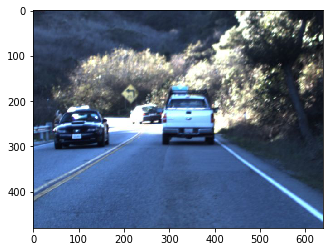

In [224]:
#Let's use the following training image as our "brightness" baseline.
ex = r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory\center\1479424603467675950.jpg'
ex = skimage.io.imread(ex)
plt.imshow(ex)
plt.show()

Convert to grey and take the average pixel value. But remember, ultimately we will use only the bottom half of the image, and it will be scaled down.

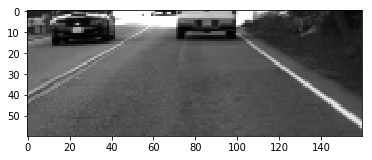

In [225]:
ex = cv2.cvtColor(ex, cv2.COLOR_RGB2GRAY)
ex = ex[240:]
ex = skimage.transform.resize(ex, (ex.shape[0] / 4, ex.shape[1] / 4))

avg_grey = np.mean(ex)
plt.imshow(ex, cmap="gray")
plt.show()

Now let's go back to our dark image and find it's average grey-scale pixel value.

In [226]:
dark_ex = skimage.io.imread(test_root + '\\' + str(c_steer_test['frame_id'][950]) + '.jpg')
dark_ex = cv2.cvtColor(dark_ex, cv2.COLOR_RGB2GRAY)
dark_ex = dark_ex[240:]
dark_ex = skimage.transform.resize(dark_ex, (dark_ex.shape[0] / 4, dark_ex.shape[1] / 4))

dark_ex_avg_grey = np.mean(dark_ex)

Find the brightness ratio between our 'gold standard' image and our darkest image. This ratio will be compared to the ratio between the gold standard and each individual image, acting as a weight on the brightness enhancement factor (which we showed to be ~10 for the darkest image) that we perform for each train / test image.

In [227]:
max_ratio = round(avg_grey / dark_ex_avg_grey, 3)

Now let's brighten the training, validation, and test images (if need be)!

In [234]:
#Brighten and crop training images

shape = (len(c_steer_train), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
c_img_array = np.zeros(shape = shape)
c_img_array.shape

#Set root directory to location of output files. Use os.path.normpath to handle '/' vs '\'
root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory')

#Load resized, normalized training image files into array
for i in range(len(c_steer_train)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_train['filename'][i]))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[240:]
    image = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    img_avg_grey = np.mean(image)
 
    #Caclulate appropriate brightness factor to use for each image
    if img_avg_grey < avg_grey:
        img_ratio = avg_grey / img_avg_grey
        bright_factor = 10 * (img_ratio/max_ratio)
    else:
        bright_factor = 1

    #Get image into "PIL" type for brigthness modification
    im = Image.open(root + '\\' + os.path.normpath(c_steer_train['filename'][i]))
    im = ImageEnhance.Brightness(im)
    im = im.enhance(bright_factor)
    
    #Convert everything back into a numpy array
    image = PIL2array(im)
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    c_img_array[i] = image_resized  

In [235]:
#Brighten and crop validation images

shape = (len(c_steer_val), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
val_img_array = np.zeros(shape = shape)
val_img_array.shape

#Set root directory to location of output files. Use os.path.normpath to handle '/' vs '\'
root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory')

#Load resized, normalized training image files into array
for i in range(len(c_steer_val)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_val['filename'][i]))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[240:]
    image = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    img_avg_grey = np.mean(image)
 
    #Caclulate appropriate brightness factor to use for each image
    if img_avg_grey < avg_grey:
        img_ratio = avg_grey / img_avg_grey
        bright_factor = 10 * (img_ratio/max_ratio)
    else:
        bright_factor = 1

    #Get image into "PIL" type for brigthness modification
    im = Image.open(root + '\\' + os.path.normpath(c_steer_val['filename'][i]))
    im = ImageEnhance.Brightness(im)
    im = im.enhance(bright_factor)
    
    #Convert everything back into a numpy array
    image = PIL2array(im)
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    val_img_array[i] = image_resized

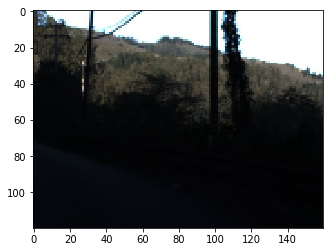

In [236]:
#Here is what the model saw in the dark image before:
plt.imshow(test_img_array[950])
plt.show()

#Now brighten test files to see the 'after'

In [ ]:
#Brighten and crop test images
shape = (len(c_steer_test), image_resized.shape[0], image_resized.shape[1], image_resized.shape[2])
test_img_array = np.zeros(shape = shape)

#Load resized, normalized test image files into array
for i in range(len(c_steer_test)):
    image = skimage.io.imread(test_root + '\\' + str(c_steer_test['frame_id'][i]) + '.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[240:]
    image = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    img_avg_grey = np.mean(image)
 
    #Caclulate appropriate brightness factor to use for each image
    if img_avg_grey < avg_grey:
        img_ratio = avg_grey / img_avg_grey
        bright_factor = 10 * (img_ratio/max_ratio)
    else:
        bright_factor = 1

    #Get image into "PIL" type for brigthness modification
    im = Image.open(test_root + '\\' + str(c_steer_test['frame_id'][i]) + '.jpg')
    im = ImageEnhance.Brightness(im)
    im = im.enhance(bright_factor)
    
    #Convert everything back into a numpy array
    image = PIL2array(im)
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    test_img_array[i] = image_resized  

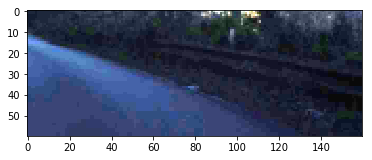

In [238]:
#Here is what the model sees after brightening exercise
plt.imshow(test_img_array[950])
plt.show()

In [237]:
#Save train and test arrays
#np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\train_1.npy', c_img_array)
#np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\val_1.npy', val_img_array)
#np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\test_1.npy', test_img_array)

#Load
c_img_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\train_1.npy')
val_img_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\val_1.npy')
test_img_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\test_1.npy')

In [239]:
#Specify inputs for model constructor below

(x_train, y_train) = (c_img_array, c_steer_train['angle'])
(x_val, y_val) = (val_img_array, c_steer_val['angle'])
(x_test, y_test) = (test_img_array, c_steer_test['steering_angle'])

In [240]:
#First test will be using 3-channel (RBG) scaled down, brightened images
m3a = model_struct_1(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 5)

Train on 27044 samples, validate on 6764 samples
Epoch 1/5
27044/27044 [==============================] - 37s - loss: 0.1788 - mean_absolute_error: 0.1841 - val_loss: 0.0273 - val_mean_absolute_error: 0.1125
Epoch 2/5
27044/27044 [==============================] - 35s - loss: 0.0605 - mean_absolute_error: 0.1382 - val_loss: 0.0175 - val_mean_absolute_error: 0.0915
Epoch 3/5
27044/27044 [==============================] - 36s - loss: 0.0420 - mean_absolute_error: 0.1100 - val_loss: 0.0139 - val_mean_absolute_error: 0.0750
Epoch 4/5
27044/27044 [==============================] - 36s - loss: 0.0313 - mean_absolute_error: 0.0942 - val_loss: 0.0117 - val_mean_absolute_error: 0.0681
Epoch 5/5
27044/27044 [==============================] - 36s - loss: 0.0250 - mean_absolute_error: 0.0846 - val_loss: 0.0131 - val_mean_absolute_error: 0.0754


In [242]:
#Score on the validation and test data

val_pred = m3a.predict(x_val)
test_pred = m3a.predict(x_test)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

Root Mean Squared Error: 0.11446
Root Mean Squared Error: 0.12437


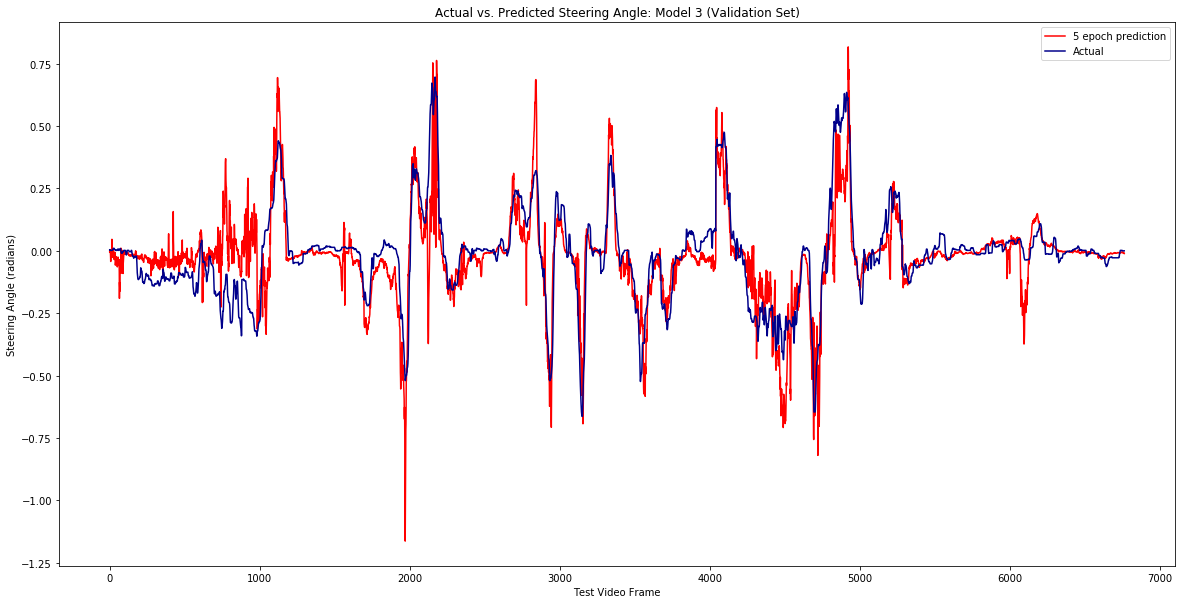

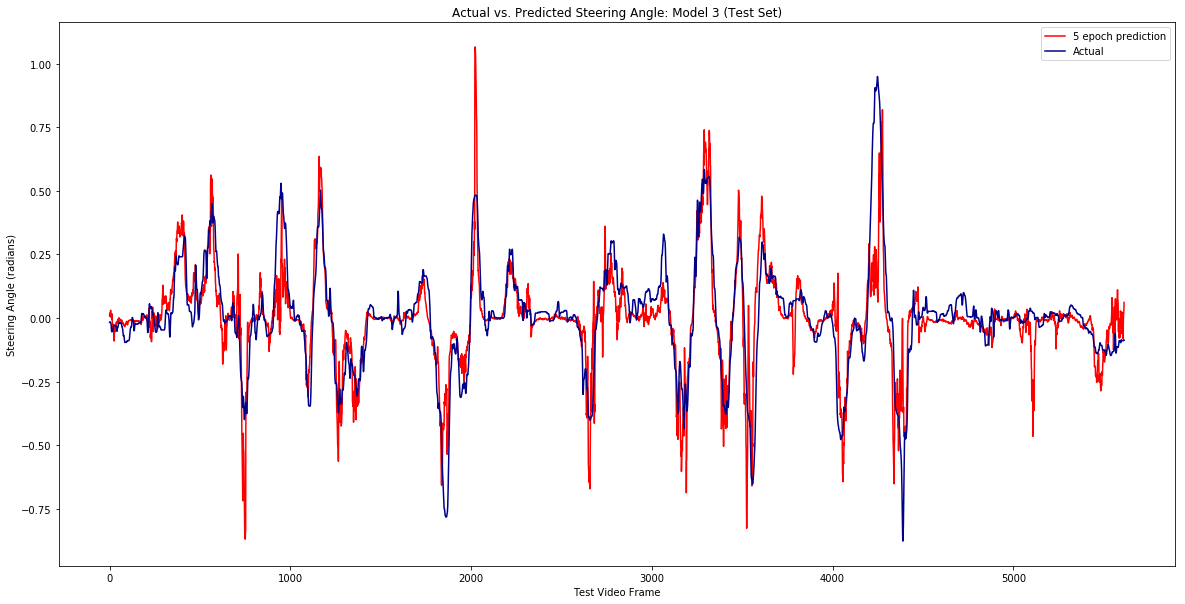

In [244]:
#Produce visualization for validation and test set predictions


plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 3 (Validation Set)')
plt.plot(val_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_val, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 3 (Test Set)')
plt.plot(test_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

The brightened, color images helped us on our test set, but RMSE slightly increased on the validation set. The RMSE scores are now very close, which is ideally what we wanted to see. Let's try one more tweak with this model - let's see if it can work comparably well in grayscale, for computational resource purposes. 

# Model 3 (Part 2: Grayscale Images)

In [11]:
#Create grayscale image (1) for image_resized dimensions in grayscale
root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory')
for i in range(1):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_train['filename'][i]))
    #Image is 480 pixels tall, so use 240
    image = image[240:]
    #Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))

In [ ]:
#CENTER CAMERA TRAIN

#Create grayscale version of brightened, cropped images and run model
shape = (len(c_steer_train), image_resized.shape[0], image_resized.shape[1])
c_img_array = np.zeros(shape = shape)
c_img_array.shape

#Set root directory to location of output files. Use os.path.normpath to handle '/' vs '\'
root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory')

#Load resized, normalized training image files into array
for i in range(len(c_steer_train)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_train['filename'][i]))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[240:]
    image = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    img_avg_grey = np.mean(image)
 
    #Caclulate appropriate brightness factor to use for each image
    if img_avg_grey < avg_grey:
        img_ratio = avg_grey / img_avg_grey
        bright_factor = 10 * (img_ratio/max_ratio)
    else:
        bright_factor = 1

    #Get image into "PIL" type for brigthness modification
    im = Image.open(root + '\\' + os.path.normpath(c_steer_train['filename'][i]))
    im = ImageEnhance.Brightness(im)
    im = im.enhance(bright_factor)
    
    #Convert everything back into a numpy array
    image = PIL2array(im)
    #Convert back to gray
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    c_img_array[i] = image_resized

In [ ]:
#CENTER CAMERA VALIDATION

#Create grayscale version of brightened, cropped images and run model
shape = (len(c_steer_val), image_resized.shape[0], image_resized.shape[1])
val_img_array = np.zeros(shape = shape)
val_img_array.shape

#Set root directory to location of output files. Use os.path.normpath to handle '/' vs '\'
root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory')

#Load resized, normalized training image files into array
for i in range(len(c_steer_train)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(c_steer_val['filename'][i]))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[240:]
    image = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    img_avg_grey = np.mean(image)
 
    #Caclulate appropriate brightness factor to use for each image
    if img_avg_grey < avg_grey:
        img_ratio = avg_grey / img_avg_grey
        bright_factor = 10 * (img_ratio/max_ratio)
    else:
        bright_factor = 1

    #Get image into "PIL" type for brigthness modification
    im = Image.open(root + '\\' + os.path.normpath(c_steer_val['filename'][i]))
    im = ImageEnhance.Brightness(im)
    im = im.enhance(bright_factor)
    
    #Convert everything back into a numpy array
    image = PIL2array(im)
    #Convert back to gray
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    val_img_array[i] = image_resized

In [ ]:
#TEST

#Create grayscale version of brightened, cropped images and run model
shape = (len(c_steer_test), image_resized.shape[0], image_resized.shape[1])
test_img_array = np.zeros(shape = shape)

#Load resized, normalized test image files into array
for i in range(len(c_steer_test)):
    image = skimage.io.imread(test_root + '\\' + str(c_steer_test['frame_id'][i]) + '.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[240:]
    image = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    img_avg_grey = np.mean(image)
 
    #Caclulate appropriate brightness factor to use for each image
    if img_avg_grey < avg_grey:
        img_ratio = avg_grey / img_avg_grey
        bright_factor = 10 * (img_ratio/max_ratio)
    else:
        bright_factor = 1

    #Get image into "PIL" type for brigthness modification
    im = Image.open(test_root + '\\' + str(c_steer_test['frame_id'][i]) + '.jpg')
    im = ImageEnhance.Brightness(im)
    im = im.enhance(bright_factor)
    
    #Convert everything back into a numpy array
    image = PIL2array(im)
    #Convert back to gray
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    test_img_array[i] = image_resized  

In [4]:
#Save train and test arrays
#np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\train_3.npy', c_img_array)
#np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\val_3.npy', val_img_array)
#np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\test_3.npy', test_img_array)

#Load
c_img_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\train_3.npy')
val_img_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\val_3.npy')
test_img_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\test_3.npy')

In [57]:
#We need a new model structure to reduce dimensionality from RBG (3 channel) to a single channel (grayscale)

def model_struct_2(x_train, y_train, x_test, y_test, batch, nb_epochs):
    
    img_rows, img_cols = image_resized.shape[0], image_resized.shape[1]

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # Building the Model
    model = Sequential()
    # First convolutional layer, note the specification of shape
    model.add(Conv2D(32, kernel_size=(3, 3),
                     #strides = (3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    #####
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['mae'])

    model.fit(x_train, y_train,
              batch_size=batch,
              epochs=nb_epochs,
              verbose=0,
              shuffle = True,
              validation_data=(x_test, y_test))
    
    return model

In [254]:
#Specify inputs for model constructor below

(x_train, y_train) = (c_img_array, c_steer_train['angle'])
(x_val, y_val) = (val_img_array, c_steer_val['angle'])
(x_test, y_test) = (test_img_array, c_steer_test['steering_angle'])

In [266]:
#First test will be using 3-channel (RBG) scaled down, brightened images
m3b = model_struct_2(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 5)

Train on 27044 samples, validate on 6764 samples
Epoch 1/5
27044/27044 [==============================] - 32s - loss: 0.0965 - mean_absolute_error: 0.1670 - val_loss: 0.0159 - val_mean_absolute_error: 0.0873
Epoch 2/5
27044/27044 [==============================] - 31s - loss: 0.0520 - mean_absolute_error: 0.1186 - val_loss: 0.0103 - val_mean_absolute_error: 0.0680
Epoch 3/5
27044/27044 [==============================] - 31s - loss: 0.0389 - mean_absolute_error: 0.1009 - val_loss: 0.0117 - val_mean_absolute_error: 0.0738
Epoch 4/5
27044/27044 [==============================] - 31s - loss: 0.0306 - mean_absolute_error: 0.0912 - val_loss: 0.0093 - val_mean_absolute_error: 0.0632
Epoch 5/5
27044/27044 [==============================] - 31s - loss: 0.0244 - mean_absolute_error: 0.0827 - val_loss: 0.0131 - val_mean_absolute_error: 0.0755


Reshape the x_val and x_test arrays so that we can use the new model structure for prediction.

In [267]:
img_rows, img_cols = image_resized.shape[0], image_resized.shape[1]
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

Root Mean Squared Error: 0.11462
Root Mean Squared Error: 0.13539


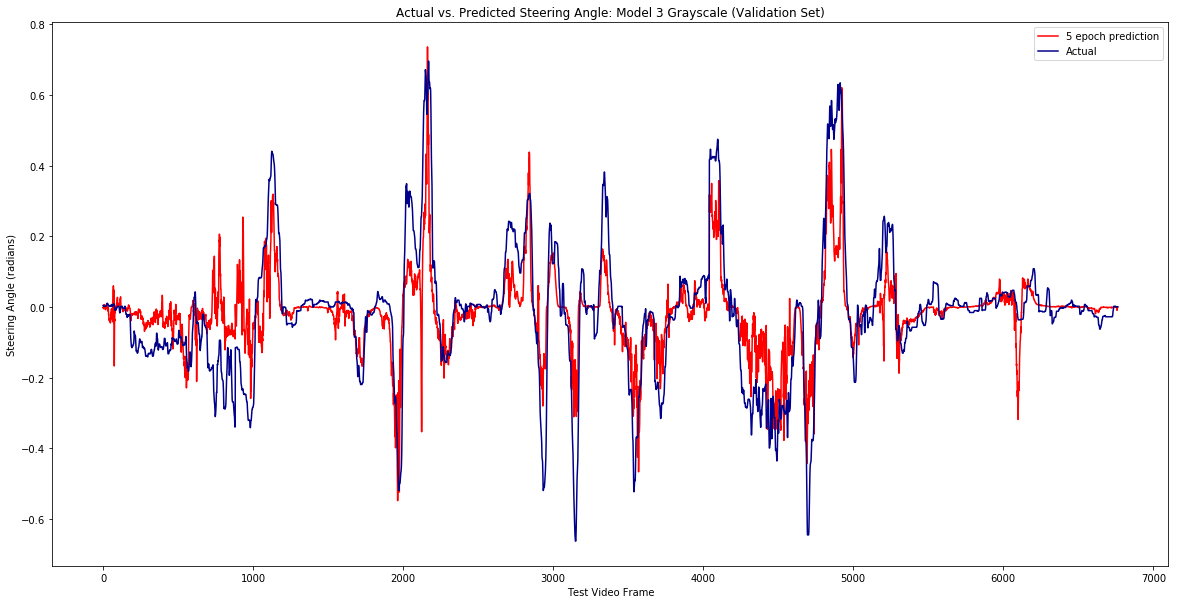

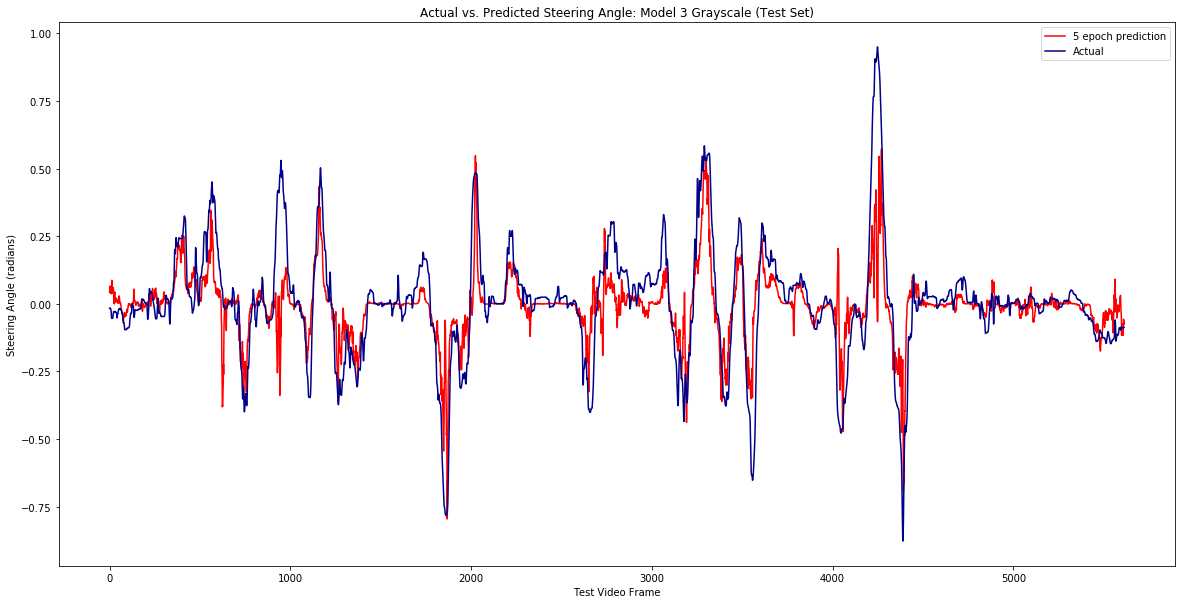

In [268]:
#Score on the validation and test data

val_pred = m3b.predict(x_val)
test_pred = m3b.predict(x_test)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

#Produce visualization for validation and test set predictions

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 3 Grayscale (Validation Set)')
plt.plot(val_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_val, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 3 Grayscale (Test Set)')
plt.plot(test_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

Hmm, the validation accuracy was unaffected by converting to grayscale, but we see a slight decrease in test accuracy. 

This could be attributed to elements of randomness, or perhaps the test set has more information embedded in color than the training or validation sets. 

In the interest of moving forward with more data and more complex models, I will stick with the grayscale version. If computer resources allow, I will also test the final model with color images.

# Model 4 Recurrence (Long Short Term Memory : LSTM)
Enhancements: Adding a temporal component to the convolutional network I have already developed could improve the model performance.

In [13]:
#In order to use LSTM layer, we need to change the dimensionality of our input matrices.

#Required input shape [#Samples, Timesteps, img_height, img_width, channels]

#Let's try first with 7 sequential images for each sample
lookback = 7

train_shape = (len(c_img_array) - lookback, lookback, image_resized.shape[0], image_resized.shape[1], 1)
lstm_train_array = np.zeros(shape = train_shape)
for i in range(len(c_img_array)- lookback):
    helper = c_img_array[i:i+lookback].reshape(1, lookback, image_resized.shape[0], image_resized.shape[1], 1)
    lstm_train_array[i] = helper
    
val_shape = (len(val_img_array) - lookback, lookback, image_resized.shape[0], image_resized.shape[1], 1)
lstm_val_array = np.zeros(shape = val_shape)
for i in range(len(val_img_array)- lookback):
    helper = val_img_array[i:i+lookback].reshape(1, lookback, image_resized.shape[0], image_resized.shape[1], 1)
    lstm_val_array[i] = helper

test_shape = (len(test_img_array) - lookback, lookback, image_resized.shape[0], image_resized.shape[1], 1)
lstm_test_array = np.zeros(shape = test_shape)
for i in range(len(test_img_array)- lookback):
    helper = test_img_array[i:i+lookback].reshape(1, lookback, image_resized.shape[0], image_resized.shape[1], 1)
    lstm_test_array[i] = helper
    
#Drop source arrays to preserve memory
c_img_array = 0
val_img_array = 0
test_img_array = 0

In [15]:
#Save train and test arrays
#np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\lstm_train_4.npy', lstm_train_array)
#np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\lstm_val_val_4.npy', lstm_val_array)

#Load
#lstm_train_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\lstm_train_4.npy')
#lstm_val_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\lstm_val_4.npy')

In [14]:
#Specify inputs for model constructor below

#Train & test set needs to be in multiples of the batch size (128)
batch = 128
train_limit = math.floor(len(lstm_train_array)/batch)*batch
val_limit = math.floor(len(lstm_val_array)/batch)*batch
test_limit = math.floor(len(lstm_test_array)/batch)*batch

#y-input for each x should be the next target value following the last image in the input sequence
#For example, our first sample will be images #0-6 (total of 7 images), and our first y sample will be #7 (x+1)

(x_train, y_train) = (lstm_train_array[: train_limit], c_steer_train['angle'][lookback : (train_limit + lookback)])
(x_val, y_val) = (lstm_val_array[: val_limit], c_steer_val['angle'][lookback : (val_limit + lookback)])
(x_test, y_test) = (lstm_test_array[: test_limit], c_steer_test['steering_angle'][lookback : (test_limit + lookback)])

In [24]:
#Let's define a new model structure with an additional Conv2D layer AND an LSTM layer, with increased dropouts to reduce overfitting

def model_struct_3(x_train, y_train, x_test, y_test, batch, nb_epochs):
    
    img_rows, img_cols = image_resized.shape[0], image_resized.shape[1]

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], lookback, 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], lookback, 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], lookback, img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], lookback, img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


        # Building the Model
    model = Sequential()
        # First convolutional layer, note the specification of shape

    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),
                              batch_input_shape=(batch, lookback, input_shape[0], input_shape[1], input_shape[2]),
                              input_shape=(None, input_shape[0], input_shape[1], input_shape[2])))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))
    
    #New Conv Layer
    model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))


    model.add(TimeDistributed(Flatten()))
        #####

    #Create LSTM layer with 128 unit output. 
    model.add(LSTM(128, return_sequences = False, stateful = False, dropout = 0.7))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.7))

    #model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss=keras.losses.mean_squared_error,
                      optimizer=keras.optimizers.Adam(),
                      metrics=['mae'])
    
    history = model.fit(x_train, y_train,
              batch_size=batch,
              epochs=nb_epochs,
              verbose=1,
              shuffle = True,
              validation_data=(x_test, y_test)) 
    
    return model, history

In [21]:
m4 = model_struct_3(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 5)

Train on 27008 samples, validate on 6656 samples
Epoch 1/5
27008/27008 [==============================] - 609s - loss: 0.0743 - mean_absolute_error: 0.1509 - val_loss: 0.0154 - val_mean_absolute_error: 0.0852
Epoch 2/5
27008/27008 [==============================] - 605s - loss: 0.0429 - mean_absolute_error: 0.1094 - val_loss: 0.0132 - val_mean_absolute_error: 0.0771
Epoch 3/5
27008/27008 [==============================] - 606s - loss: 0.0357 - mean_absolute_error: 0.0968 - val_loss: 0.0099 - val_mean_absolute_error: 0.0601
Epoch 4/5
27008/27008 [==============================] - 606s - loss: 0.0302 - mean_absolute_error: 0.0901 - val_loss: 0.0125 - val_mean_absolute_error: 0.0640
Epoch 5/5
27008/27008 [==============================] - 606s - loss: 0.0243 - mean_absolute_error: 0.0831 - val_loss: 0.0107 - val_mean_absolute_error: 0.0623


In [27]:
#Score on the validation and test data
val_pred = m4[0].predict(x_val, batch_size = 128)
test_pred = m4[0].predict(x_test, batch_size = 128)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

Root Mean Squared Error: 0.1034
Root Mean Squared Error: 0.12371


In [54]:
train_mse_5 = m4[1].history['loss']
val_mse_5 = m4[1].history['val_loss']
epochs = np.arange(10)+1

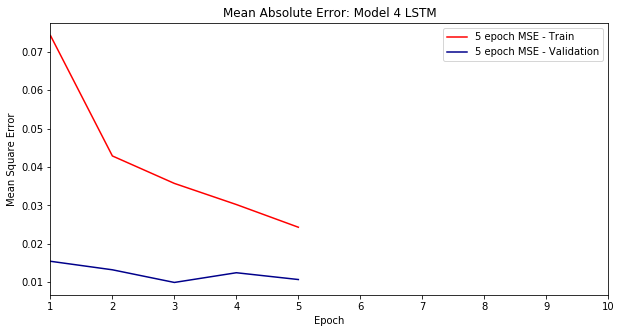

In [73]:
plt.figure(figsize = (10,5))
plt.title('Mean Absolute Error: Model 4 LSTM')
plt.xlabel('Epoch')
plt.xlim(xmin=1)
dim=np.arange(1,11,1)
plt.plot(np.append(np.roll(train_mse_5,1),train_mse_5[len(train_mse_5)-1]), label = '5 epoch MSE - Train', c = 'red')
plt.plot(np.append(np.roll(val_mse_5,1),val_mse_5[len(val_mse_5)-1]), label = '5 epoch MSE - Validation', c = 'darkblue')
plt.xticks(dim)
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

Root Mean Squared Error: 0.1034
Root Mean Squared Error: 0.12371


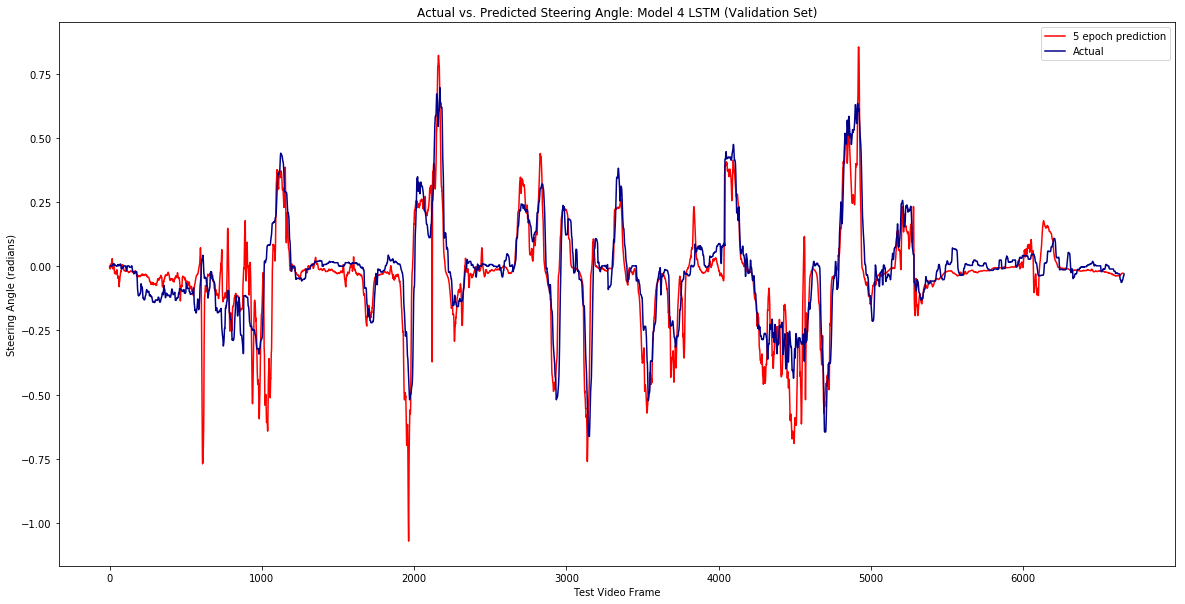

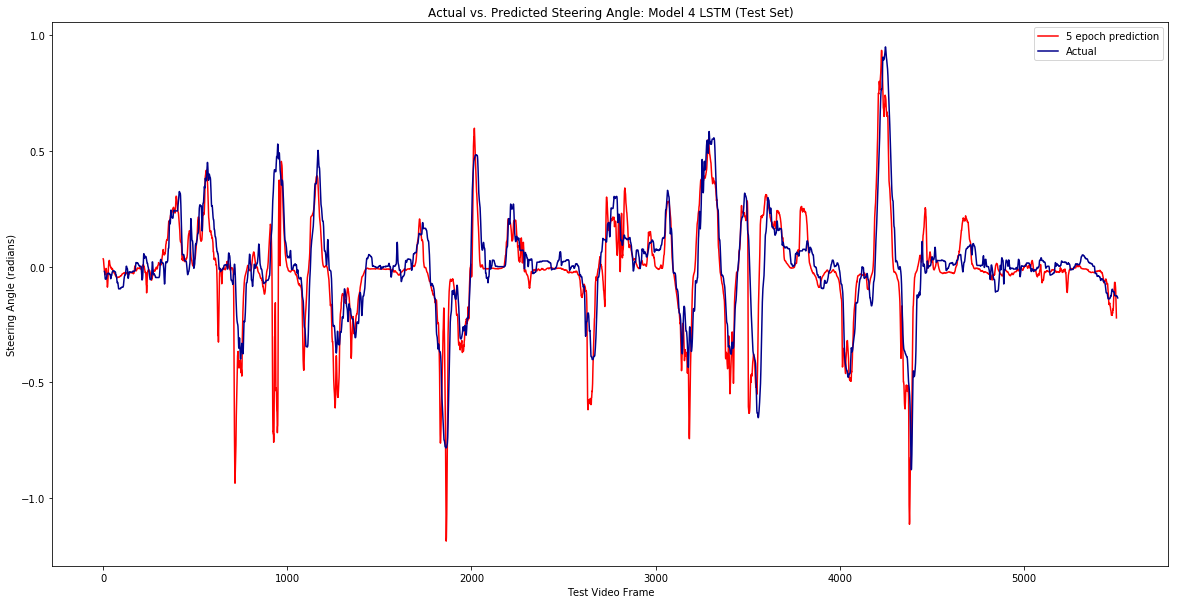

In [26]:
#Score on the validation and test data

val_pred = m4[0].predict(x_val, batch_size = 128)
test_pred = m4[0].predict(x_test, batch_size = 128)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

#Produce visualization for validation and test set predictions

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 4 LSTM (Validation Set)')
plt.plot(val_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_val, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 4 LSTM (Test Set)')
plt.plot(test_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

In [70]:
#Add some additional epochs for training
m4b = model_struct_3(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 10)

Train on 27008 samples, validate on 6656 samples
Epoch 1/10
27008/27008 [==============================] - 609s - loss: 0.0729 - mean_absolute_error: 0.1495 - val_loss: 0.0191 - val_mean_absolute_error: 0.0927
Epoch 2/10
27008/27008 [==============================] - 606s - loss: 0.0443 - mean_absolute_error: 0.1091 - val_loss: 0.0093 - val_mean_absolute_error: 0.0632
Epoch 3/10
27008/27008 [==============================] - 606s - loss: 0.0362 - mean_absolute_error: 0.0967 - val_loss: 0.0103 - val_mean_absolute_error: 0.0638
Epoch 4/10
27008/27008 [==============================] - 606s - loss: 0.0308 - mean_absolute_error: 0.0905 - val_loss: 0.0117 - val_mean_absolute_error: 0.0674
Epoch 5/10
27008/27008 [==============================] - 606s - loss: 0.0236 - mean_absolute_error: 0.0823 - val_loss: 0.0093 - val_mean_absolute_error: 0.0584
Epoch 6/10
27008/27008 [==============================] - 606s - loss: 0.0209 - mean_absolute_error: 0.0775 - val_loss: 0.0085 - val_mean_absolute

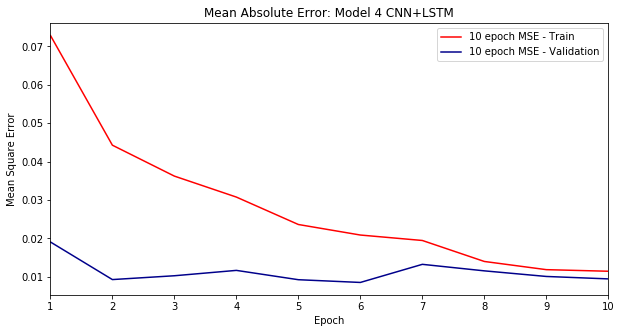

Root Mean Squared Error: 0.09731
Root Mean Squared Error: 0.11836


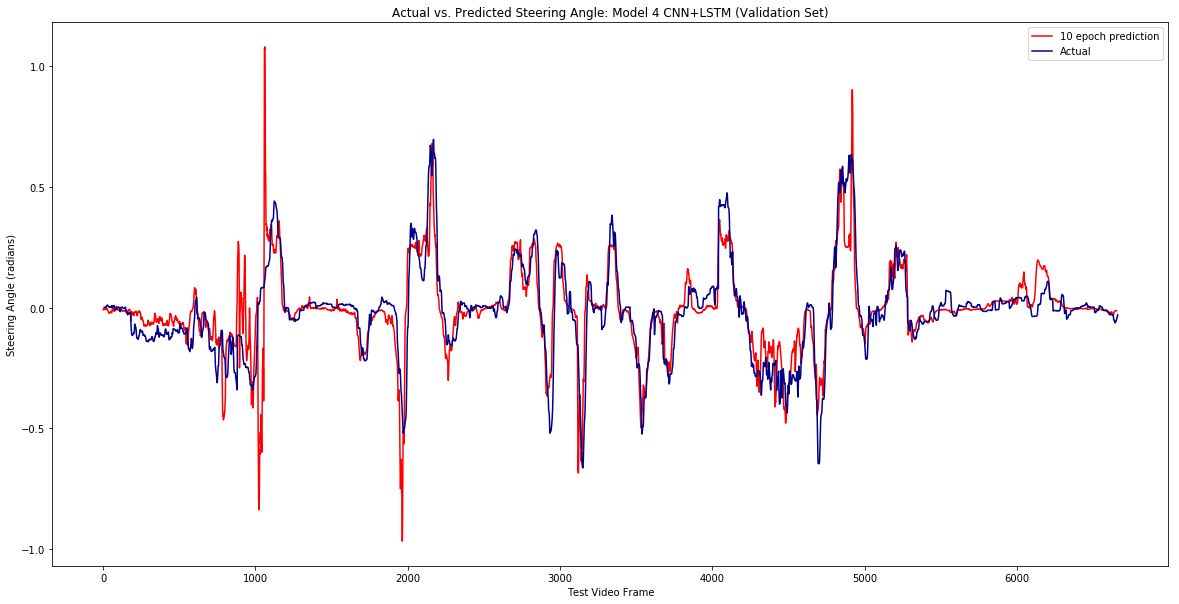

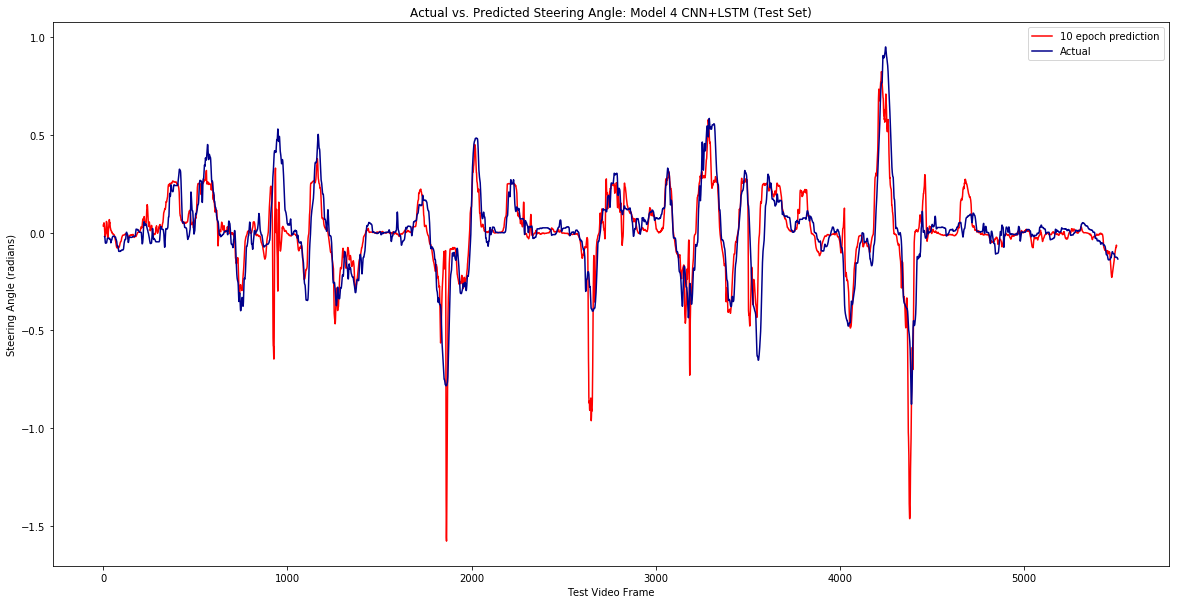

In [75]:
train_mse_10 = m4b[1].history['loss']
val_mse_10 = m4b[1].history['val_loss']
epochs = np.arange(10)+1

plt.figure(figsize = (10,5))
plt.title('Mean Absolute Error: Model 4 CNN+LSTM')
plt.xlabel('Epoch')
plt.xlim(xmin=1)
dim=np.arange(1,11,1)
plt.plot(np.append(np.roll(train_mse_10,1),train_mse_10[len(train_mse_10)-1]), label = '10 epoch MSE - Train', c = 'red')
plt.plot(np.append(np.roll(val_mse_10,1),val_mse_10[len(val_mse_10)-1]), label = '10 epoch MSE - Validation', c = 'darkblue')
plt.xticks(dim)
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

#Score on the validation and test data

val_pred = m4b[0].predict(x_val, batch_size = 128)
test_pred = m4b[0].predict(x_test, batch_size = 128)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

#Produce visualization for validation and test set predictions

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 4 CNN+LSTM (Validation Set)')
plt.plot(val_pred, label = '10 epoch prediction', c = 'red')
plt.plot(y_val, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 4 CNN+LSTM (Test Set)')
plt.plot(test_pred, label = '10 epoch prediction', c = 'red')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

In [78]:
#Save models 
m4[0].save(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m4.h5')  
m4b[0].save(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m4b.h5')  

#Returns a compiled model identical to the previous one
m4 = load_model(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m4.h5')
m4b = load_model(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m4b.h5')

In [81]:
#Save the model predictions
z = m4.predict(x_val, batch_size = 128)
z2 = m4.predict(x_test, batch_size = 128)

z3 = m4b.predict(x_val, batch_size = 128)
z4 = m4b.predict(x_test, batch_size = 128)

preds_df = pd.DataFrame(z)
preds_df.to_csv(r'C:\Users\ryan13829\Desktop\Thinkful\m4_val_preds.csv')
preds_df = pd.DataFrame(z2)
preds_df.to_csv(r'C:\Users\ryan13829\Desktop\Thinkful\m4_test_preds.csv')
preds_df = pd.DataFrame(z3)
preds_df.to_csv(r'C:\Users\ryan13829\Desktop\Thinkful\m4b_val_preds.csv')
preds_df = pd.DataFrame(z4)
preds_df.to_csv(r'C:\Users\ryan13829\Desktop\Thinkful\m4b_test_preds.csv')

# Model 5 (Part 1: Left & Right Camera Data)
Enhancements: Add left and right training data to the training set. Find appropriate steering angle offset to use for left and right cameras (using same steering angle as for center camera would be sub-optimal).

In [19]:
#LEFT 

l_steer_train = pd.read_csv(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory\interpolated.csv')
l_steer_train = l_steer_train[l_steer_train['frame_id'] == 'left_camera'][['timestamp', 'filename', 'angle']]
l_steer_train.reset_index(inplace = True)

#Validation / holdout set should be end sequences of each of the 5 separate trips in the training set. Using random images from 
#each trip would result in model having "seen" very similar images between the fit and predict steps
l_steer_train['trip'] = l_steer_train['timestamp'].apply(trip_no)

#Remove trip 6 (the test set) from the c_steer_train DF
l_steer_train = l_steer_train[l_steer_train['trip'] != 6]
l_steer_train.reset_index(inplace = True)

#Remove 20% from train samples from l_steer_train

train_df = pd.DataFrame()

for trip in range(5):
    split = math.floor(len(l_steer_train[l_steer_train['trip'] == trip+1]) * 0.8)
    train_df = train_df.append(l_steer_train[l_steer_train['trip'] == trip+1][: split])
    
l_steer_train = train_df

#Drop and reset indices
l_steer_train.drop('level_0', axis = 1, inplace = True)
l_steer_train.reset_index(inplace = True)

#RIGHT

r_steer_train = pd.read_csv(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory\interpolated.csv')
r_steer_train = r_steer_train[r_steer_train['frame_id'] == 'right_camera'][['timestamp', 'filename', 'angle']]
r_steer_train.reset_index(inplace = True)

#Validation / holdout set should be end sequences of each of the 5 separate trips in the training set. Using random images from 
#each trip would result in model having "seen" very similar images between the fit and predict steps
r_steer_train['trip'] = r_steer_train['timestamp'].apply(trip_no)

#Remove trip 6 (the test set) from the c_steer_train DF
r_steer_train = r_steer_train[r_steer_train['trip'] != 6]
r_steer_train.reset_index(inplace = True)

#Remove 20% from train samples from r_steer_train

train_df = pd.DataFrame()

for trip in range(5):
    split = math.floor(len(r_steer_train[r_steer_train['trip'] == trip+1]) * 0.8)
    train_df = train_df.append(r_steer_train[r_steer_train['trip'] == trip+1][: split])
    
r_steer_train = train_df

#Drop and reset indices
r_steer_train.drop('level_0', axis = 1, inplace = True)
r_steer_train.reset_index(inplace = True)

In [ ]:
#Initialize Left & Right Training Arrays
shape = (len(l_steer_train), image_resized.shape[0], image_resized.shape[1])
l_img_array = np.zeros(shape = shape)

shape = (len(r_steer_train), image_resized.shape[0], image_resized.shape[1])
r_img_array = np.zeros(shape = shape)

In [ ]:
#LEFT

#Create grayscale version of brightened, cropped images and run model

#Set root directory to location of output files. Use os.path.normpath to handle '/' vs '\'
root = os.path.normpath(r'C:\Users\ryan13829\Desktop\Thinkful\docker_output_directory')

#Load resized, normalized training image files into array
for i in range(len(l_steer_train)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(l_steer_train['filename'][i]))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[240:]
    image = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    img_avg_grey = np.mean(image)
 
    #Caclulate appropriate brightness factor to use for each image
    if img_avg_grey < avg_grey:
        img_ratio = avg_grey / img_avg_grey
        bright_factor = 10 * (img_ratio/max_ratio)
    else:
        bright_factor = 1

    #Get image into "PIL" type for brigthness modification
    im = Image.open(root + '\\' + os.path.normpath(l_steer_train['filename'][i]))
    im = ImageEnhance.Brightness(im)
    im = im.enhance(bright_factor)
    
    #Convert everything back into a numpy array
    image = PIL2array(im)
    #Convert back to gray
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    l_img_array[i] = image_resized

#RIGHT

#Load resized, normalized training image files into array
for i in range(len(r_steer_train)):
    image = skimage.io.imread(root + '\\' + os.path.normpath(r_steer_train['filename'][i]))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[240:]
    image = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    img_avg_grey = np.mean(image)
 
    #Caclulate appropriate brightness factor to use for each image
    if img_avg_grey < avg_grey:
        img_ratio = avg_grey / img_avg_grey
        bright_factor = 10 * (img_ratio/max_ratio)
    else:
        bright_factor = 1

    #Get image into "PIL" type for brigthness modification
    im = Image.open(root + '\\' + os.path.normpath(r_steer_train['filename'][i]))
    im = ImageEnhance.Brightness(im)
    im = im.enhance(bright_factor)
    
    #Convert everything back into a numpy array
    image = PIL2array(im)
    #Convert back to gray
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #Image is 480 pixels tall, so use 240 to cut in half
    image = image[240:]
    image_resized = skimage.transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4))
    r_img_array[i] = image_resized
    
    
#Save grayscale train and test sets
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\l_train_3.npy', l_img_array)
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\r_train_3.npy', r_img_array)

In [5]:
#Load
l_img_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\l_train_3.npy')
r_img_array = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\r_train_3.npy')

Let's see if the left and right camera images benefit the CNN model we defined earlier. If so, we will add these images to the CNN+LSTM model training, and re-run.

In [63]:
#Need to find the correct steering angle offset for left and right camera images:

#Concatenate the center, left, and right train data. 
full_x_train_array = np.vstack((c_img_array, l_img_array, r_img_array))

#Adjust the steering angle in the train set to account for the different angle for the left and right cameras.
#Use model_struct_2 (turn off model verbosity) and test for 5 epochs to determine which of the adjustment angles works best.

adjs = [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15]
image_resized = np.zeros(shape = (60, 160))

for adj in adjs:
    full_y_train_array = c_steer_train['angle'].append(l_steer_train['angle'] - adj).append(r_steer_train['angle'] + adj)


    (x_val, y_val) = (val_img_array, c_steer_val['angle'])
    (x_test, y_test) = (test_img_array, c_steer_test['steering_angle'])

    m5a_2 = model_struct_2(full_x_train_array, full_y_train_array, x_val, y_val, batch = 128, nb_epochs = 5)

    #RMSE using just center camera below. This will be our target:

    #Validation set: Root Mean Squared Error: 0.11462
    #Test set: Root Mean Squared Error: 0.13539

    #Score on the validation and test data
    img_rows, img_cols = image_resized.shape[0], image_resized.shape[1]
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

    val_pred = m5a_2.predict(x_val)
    test_pred = m5a_2.predict(x_test)
    print('Adjustment angle in radians: ', adj)
    rmse(val_pred, y_val)
    rmse(test_pred, y_test)

Adjustment angle in radians:  -0.15
Root Mean Squared Error: 0.14834
Root Mean Squared Error: 0.16345
Adjustment angle in radians:  -0.1
Root Mean Squared Error: 0.1088
Root Mean Squared Error: 0.13807
Adjustment angle in radians:  -0.05
Root Mean Squared Error: 0.11337
Root Mean Squared Error: 0.1248
Adjustment angle in radians:  0
Root Mean Squared Error: 0.10439
Root Mean Squared Error: 0.13396
Adjustment angle in radians:  0.05
Root Mean Squared Error: 0.10045
Root Mean Squared Error: 0.12737
Adjustment angle in radians:  0.1
Root Mean Squared Error: 0.09289
Root Mean Squared Error: 0.11658
Adjustment angle in radians:  0.15
Root Mean Squared Error: 0.08652
Root Mean Squared Error: 0.11135


In [67]:
#Sharper angle adjustments appear to benefit the model. Let's explore higher angles.

adjs = [0.2, 0.25, 0.3, 0.35]
image_resized = np.zeros(shape = (60, 160))

for adj in adjs:
    full_y_train_array = c_steer_train['angle'].append(l_steer_train['angle'] - adj).append(r_steer_train['angle'] + adj)


    (x_val, y_val) = (val_img_array, c_steer_val['angle'])
    (x_test, y_test) = (test_img_array, c_steer_test['steering_angle'])

    m5a_2 = model_struct_2(full_x_train_array, full_y_train_array, x_val, y_val, batch = 128, nb_epochs = 5)

    #RMSE using just center camera below. This will be our target:

    #Validation set: Root Mean Squared Error: 0.11462
    #Test set: Root Mean Squared Error: 0.13539

    #Score on the validation and test data
    img_rows, img_cols = image_resized.shape[0], image_resized.shape[1]
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

    val_pred = m5a_2.predict(x_val)
    test_pred = m5a_2.predict(x_test)
    print('Adjustment angle in radians: ', adj)
    rmse(val_pred, y_val)
    rmse(test_pred, y_test)

Adjustment angle in radians:  0.2
Root Mean Squared Error: 0.08518
Root Mean Squared Error: 0.10201
Adjustment angle in radians:  0.25
Root Mean Squared Error: 0.0904
Root Mean Squared Error: 0.11246
Adjustment angle in radians:  0.3
Root Mean Squared Error: 0.10169
Root Mean Squared Error: 0.10068
Adjustment angle in radians:  0.35
Root Mean Squared Error: 0.08202
Root Mean Squared Error: 0.10001


Root Mean Squared Error: 0.08557
Root Mean Squared Error: 0.10032


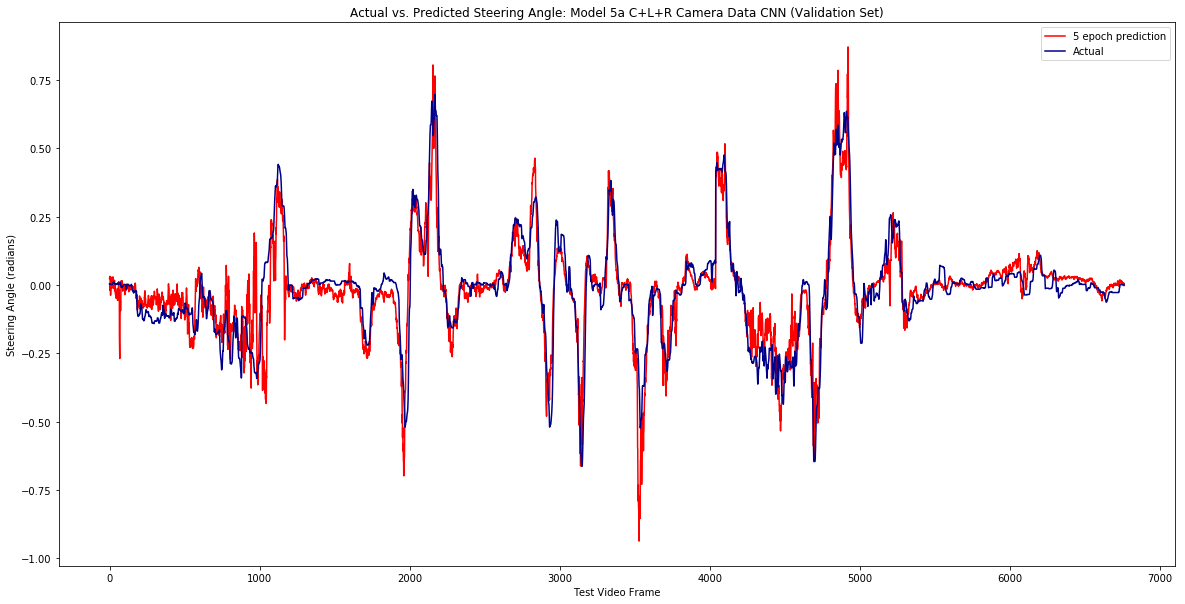

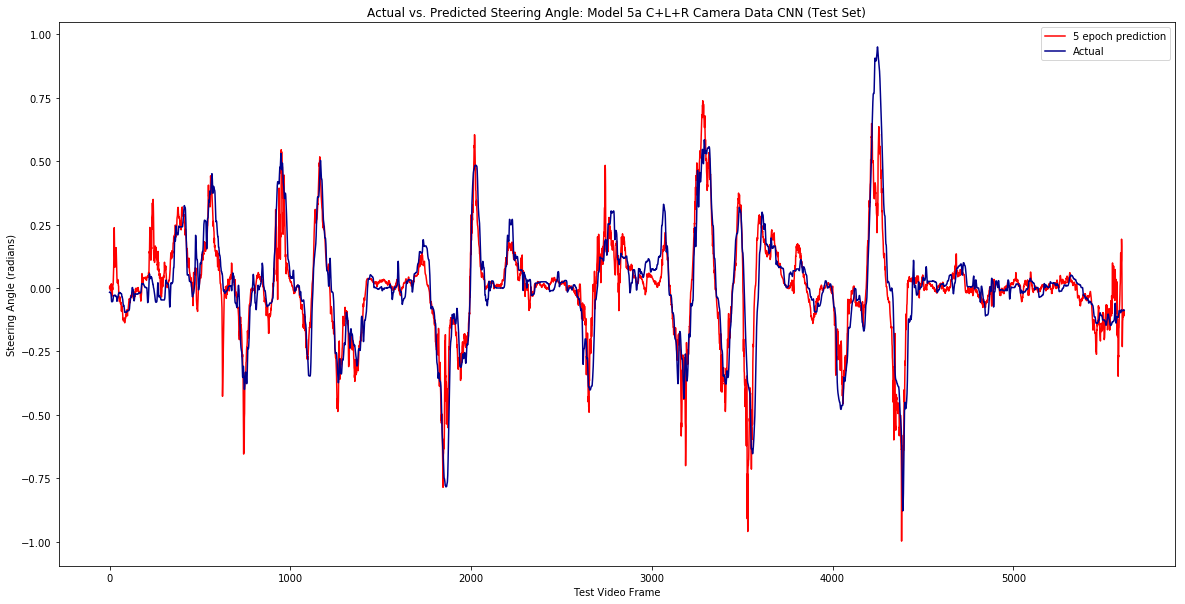

In [69]:
#0.2 seems to be the most stable... let's use that.

#Concatenate the center, left, and right train data. 
full_x_train_array = np.vstack((c_img_array, l_img_array, r_img_array))

#Adjust the steering angle in the train set to account for the different angle for the left and right cameras
full_y_train_array = c_steer_train['angle'].append(l_steer_train['angle'] - 0.2).append(r_steer_train['angle'] + 0.2)


(x_val, y_val) = (val_img_array, c_steer_val['angle'])
(x_test, y_test) = (test_img_array, c_steer_test['steering_angle'])

m5a_2 = model_struct_2(full_x_train_array, full_y_train_array, x_val, y_val, batch = 128, nb_epochs = 10)

#RMSE using just center camera below. This will be our target:

#Validation set: Root Mean Squared Error: 0.11462
#Test set: Root Mean Squared Error: 0.13539

#Score on the validation and test data
img_rows, img_cols = image_resized.shape[0], image_resized.shape[1]
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

val_pred = m5a_2.predict(x_val)
test_pred = m5a_2.predict(x_test)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

#Produce visualization for validation and test set predictions

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 5a C+L+R Camera Data CNN (Validation Set)')
plt.plot(val_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_val, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 5a C+L+R Camera Data CNN (Test Set)')
plt.plot(test_pred, label = '5 epoch prediction', c = 'red')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

OK the RMSE improved quite a bit using a 0.2 offset for the left and right camera images. Scores improved from val, test = (11.5%, 13.5%) to (8.6%, 10.0%) using just the CNN model. Let's now incorporate these images into the superior CNN + LSTM model.

We've already got the center train, validation, and test sets in the proper format for the CNN + LSTM model. We just need left and right camera images now. 

In [8]:
#In order to use LSTM layer, we need to change the dimensionality of our input matrices.

#Required input shape [#Samples, Timesteps, img_height, img_width, channels]

#Let's try to use 3 images in our "lookback"; shrinking so as to prevent memory issues
lookback = 3

train_shape = (len(c_img_array) - lookback, lookback, image_resized.shape[0], image_resized.shape[1], 1)
lstm_train_array = np.zeros(shape = train_shape)
for i in range(len(c_img_array)- lookback):
    helper = c_img_array[i:i+lookback].reshape(1, lookback, image_resized.shape[0], image_resized.shape[1], 1)
    lstm_train_array[i] = helper
    
val_shape = (len(val_img_array) - lookback, lookback, image_resized.shape[0], image_resized.shape[1], 1)
lstm_val_array = np.zeros(shape = val_shape)
for i in range(len(val_img_array)- lookback):
    helper = val_img_array[i:i+lookback].reshape(1, lookback, image_resized.shape[0], image_resized.shape[1], 1)
    lstm_val_array[i] = helper

test_shape = (len(test_img_array) - lookback, lookback, image_resized.shape[0], image_resized.shape[1], 1)
lstm_test_array = np.zeros(shape = test_shape)
for i in range(len(test_img_array)- lookback):
    helper = test_img_array[i:i+lookback].reshape(1, lookback, image_resized.shape[0], image_resized.shape[1], 1)
    lstm_test_array[i] = helper
    
#Drop source arrays to preserve memory
c_img_array = 0
val_img_array = 0
test_img_array = 0

In [9]:
l_train_shape = (len(l_img_array) - lookback, lookback, image_resized.shape[0], image_resized.shape[1], 1)
l_lstm_train_array = np.zeros(shape = l_train_shape)
for i in range(len(l_img_array)- lookback):
    helper = l_img_array[i:i+lookback].reshape(1, lookback, image_resized.shape[0], image_resized.shape[1], 1)
    l_lstm_train_array[i] = helper
    
#Drop l_img_array to free memory
l_img_array = 0

In [10]:
r_train_shape = (len(r_img_array) - lookback, lookback, image_resized.shape[0], image_resized.shape[1], 1)
r_lstm_train_array = np.zeros(shape = r_train_shape)
for i in range(len(r_img_array)- lookback):
    helper = r_img_array[i:i+lookback].reshape(1, lookback, image_resized.shape[0], image_resized.shape[1], 1)
    r_lstm_train_array[i] = helper
    
#Drop l_img_array to free memory
r_img_array = 0

In [11]:
#Specify inputs for model constructor below

#Train & test set needs to be in multiples of the batch size (128)
batch = 128
c_train_limit = math.floor(len(lstm_train_array)/batch)*batch
l_train_limit = math.floor(len(l_lstm_train_array)/batch)*batch
r_train_limit = math.floor(len(r_lstm_train_array)/batch)*batch
val_limit = math.floor(len(lstm_val_array)/batch)*batch
test_limit = math.floor(len(lstm_test_array)/batch)*batch

In [20]:
(x_train1, y_train1) = (lstm_train_array[: c_train_limit], c_steer_train['angle'][lookback : (c_train_limit + lookback)])
lstm_train_array = 0
(x_train2, y_train2) = (l_lstm_train_array[: l_train_limit], l_steer_train['angle'][lookback : (l_train_limit + lookback)] - 0.2)
l_lstm_train_array = 0
(x_train3, y_train3) = (r_lstm_train_array[: r_train_limit], r_steer_train['angle'][lookback : (r_train_limit + lookback)] + 0.2)
r_lstm_train_array = 0

In [21]:
#Concatenate
x_train = np.vstack((x_train1, x_train2, x_train3))
y_train = np.hstack((y_train1, y_train2, y_train3))

In [22]:
#Free memory
x_train1 = 0 
x_train2 = 0 
x_train3 = 0 

y_train1 = 0 
y_train2 = 0 
y_train3 = 0 

In [23]:
#y-input for each x should be the next target value following the last image in the input sequence
#For example, our first sample will be images #0-2 (total of 3 images), and our first y sample will be #3 (x+1)

#(x_train, y_train) = (lstm_train_array[: train_limit], c_steer_train['angle'][lookback : (train_limit + lookback)])
(x_val, y_val) = (lstm_val_array[: val_limit], c_steer_val['angle'][lookback : (val_limit + lookback)])
lstm_val_array = 0 
(x_test, y_test) = (lstm_test_array[: test_limit], c_steer_test['steering_angle'][lookback : (test_limit + lookback)])
lstm_test_array = 0

In [25]:
m51a = model_struct_3(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 5)

Train on 81024 samples, validate on 6656 samples
Epoch 1/5
81024/81024 [==============================] - 740s - loss: 0.0728 - mean_absolute_error: 0.1651 - val_loss: 0.0106 - val_mean_absolute_error: 0.0635
Epoch 2/5
81024/81024 [==============================] - 735s - loss: 0.0426 - mean_absolute_error: 0.1155 - val_loss: 0.0074 - val_mean_absolute_error: 0.0581
Epoch 3/5
81024/81024 [==============================] - 735s - loss: 0.0344 - mean_absolute_error: 0.1033 - val_loss: 0.0074 - val_mean_absolute_error: 0.0569
Epoch 4/5
81024/81024 [==============================] - 735s - loss: 0.0285 - mean_absolute_error: 0.0939 - val_loss: 0.0073 - val_mean_absolute_error: 0.0547
Epoch 5/5
81024/81024 [==============================] - 735s - loss: 0.0233 - mean_absolute_error: 0.0866 - val_loss: 0.0060 - val_mean_absolute_error: 0.0521


In [26]:
#Save models 
m51a[0].save(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m51a.h5')  

train_mse_5 = np.asarray(m51a[1].history['loss'])
val_mse_5 = np.asarray(m51a[1].history['val_loss'])

#Save loss arrays 
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51a_train_mse_5.npy', train_mse_5)
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51a_val_mse_5.npy', val_mse_5)

In [27]:
m51b = model_struct_3(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 10)

#Save models 
m51b[0].save(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m51b.h5')  

train_mse_10 = np.asarray(m51b[1].history['loss'])
val_mse_10 = np.asarray(m51b[1].history['val_loss'])

#Save loss arrays 
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51b_train_mse_10.npy', train_mse_10)
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51b_val_mse_10.npy', val_mse_10)

Train on 81024 samples, validate on 6656 samples
Epoch 1/10
81024/81024 [==============================] - 738s - loss: 0.0718 - mean_absolute_error: 0.1615 - val_loss: 0.0089 - val_mean_absolute_error: 0.0632
Epoch 2/10
81024/81024 [==============================] - 736s - loss: 0.0439 - mean_absolute_error: 0.1155 - val_loss: 0.0090 - val_mean_absolute_error: 0.0606
Epoch 3/10
81024/81024 [==============================] - 736s - loss: 0.0325 - mean_absolute_error: 0.0988 - val_loss: 0.0098 - val_mean_absolute_error: 0.0611
Epoch 4/10
81024/81024 [==============================] - 736s - loss: 0.0277 - mean_absolute_error: 0.0918 - val_loss: 0.0058 - val_mean_absolute_error: 0.0521
Epoch 5/10
81024/81024 [==============================] - 736s - loss: 0.0242 - mean_absolute_error: 0.0869 - val_loss: 0.0067 - val_mean_absolute_error: 0.0552
Epoch 6/10
81024/81024 [==============================] - 736s - loss: 0.0214 - mean_absolute_error: 0.0827 - val_loss: 0.0072 - val_mean_absolute

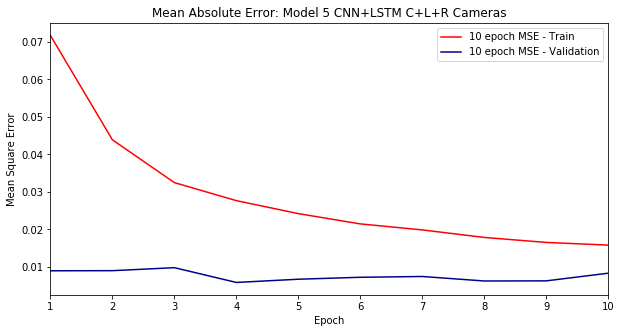

Root Mean Squared Error: 0.09109
Root Mean Squared Error: 0.10654


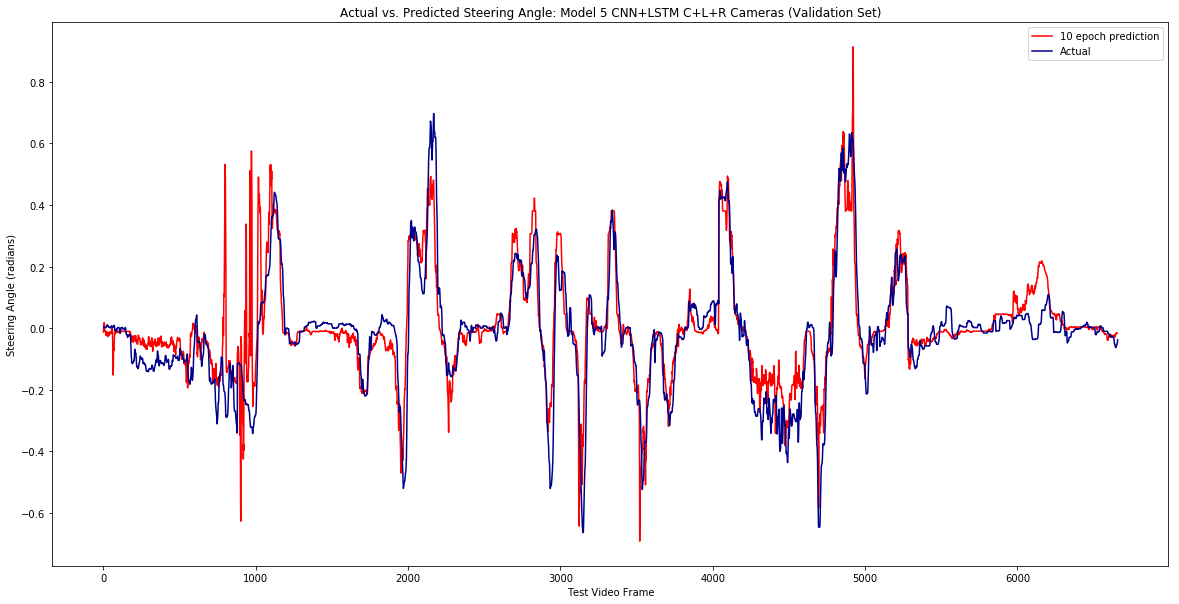

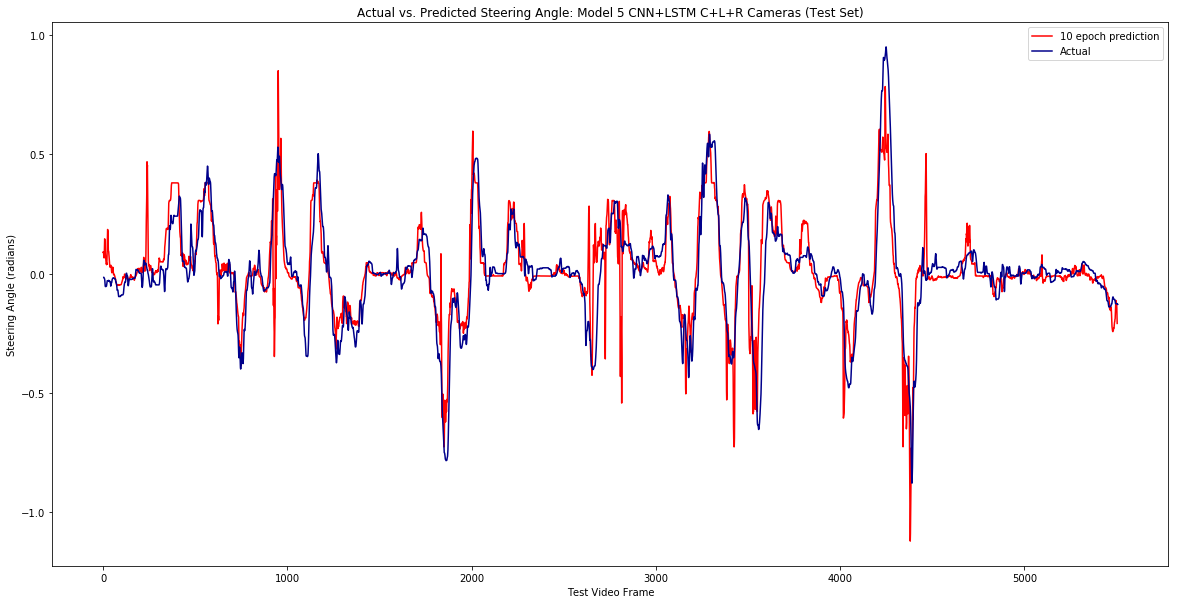

In [28]:
#Load
train_mse_10 = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51b_train_mse_10.npy')
val_mse_10 = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51b_val_mse_10.npy')

#Returns a compiled model identical to the previous one
m51b = load_model(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m51b.h5')

plt.figure(figsize = (10,5))
plt.title('Mean Absolute Error: Model 5 CNN+LSTM C+L+R Cameras')
plt.xlabel('Epoch')
plt.xlim(xmin=1)
dim=np.arange(1,11,1)
plt.plot(np.append(np.roll(train_mse_10,1),train_mse_10[len(train_mse_10)-1]), label = '10 epoch MSE - Train', c = 'red')
plt.plot(np.append(np.roll(val_mse_10,1),val_mse_10[len(val_mse_10)-1]), label = '10 epoch MSE - Validation', c = 'darkblue')
plt.xticks(dim)
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

#Score on the validation and test data

val_pred = m51b.predict(x_val, batch_size = 128)
test_pred = m51b.predict(x_test, batch_size = 128)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

#Produce visualization for validation and test set predictions

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 5 CNN+LSTM C+L+R Cameras (Validation Set)')
plt.plot(val_pred, label = '10 epoch prediction', c = 'red')
plt.plot(y_val, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 5 CNN+LSTM C+L+R Cameras (Test Set)')
plt.plot(test_pred, label = '10 epoch prediction', c = 'red')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

In [29]:
#Final model structure attempt - additional LSTM layer and lower dropouts in later layers

def model_struct_4(x_train, y_train, x_test, y_test, batch, nb_epochs):
    
    img_rows, img_cols = image_resized.shape[0], image_resized.shape[1]

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], lookback, 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], lookback, 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], lookback, img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], lookback, img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


        # Building the Model
    model = Sequential()
        # First convolutional layer, note the specification of shape

    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),
                              batch_input_shape=(batch, lookback, input_shape[0], input_shape[1], input_shape[2]),
                              input_shape=(None, input_shape[0], input_shape[1], input_shape[2])))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))
    
    #New Conv Layer
    model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))


    model.add(TimeDistributed(Flatten()))
        #####

    #Create LSTM layer with 128 unit output. 
    model.add(LSTM(256, return_sequences = True, stateful = False, dropout = 0.5))
    model.add(LSTM(128, return_sequences = False, stateful = False, dropout = 0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss=keras.losses.mean_squared_error,
                      optimizer=keras.optimizers.Adam(),
                      metrics=['mae'])
    
    history = model.fit(x_train, y_train,
              batch_size=batch,
              epochs=nb_epochs,
              verbose=1,
              shuffle = True,
              validation_data=(x_test, y_test)) 
    
    return model, history

In [30]:
m51e = model_struct_4(x_train, y_train, x_val, y_val, batch = 128, nb_epochs = 10)

#Save models 
m51e[0].save(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m51e.h5')  

train_mse_10 = np.asarray(m51e[1].history['loss'])
val_mse_10 = np.asarray(m51e[1].history['val_loss'])

#Save loss arrays 
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51e_train_mse_10.npy', train_mse_10)
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51e_val_mse_10.npy', val_mse_10)

Train on 81024 samples, validate on 6656 samples
Epoch 1/10
81024/81024 [==============================] - 745s - loss: 0.0591 - mean_absolute_error: 0.1415 - val_loss: 0.0131 - val_mean_absolute_error: 0.0702
Epoch 2/10
81024/81024 [==============================] - 741s - loss: 0.0330 - mean_absolute_error: 0.0989 - val_loss: 0.0107 - val_mean_absolute_error: 0.0598
Epoch 3/10
81024/81024 [==============================] - 741s - loss: 0.0252 - mean_absolute_error: 0.0844 - val_loss: 0.0083 - val_mean_absolute_error: 0.0552
Epoch 4/10
81024/81024 [==============================] - 740s - loss: 0.0208 - mean_absolute_error: 0.0772 - val_loss: 0.0102 - val_mean_absolute_error: 0.0599
Epoch 5/10
81024/81024 [==============================] - 741s - loss: 0.0190 - mean_absolute_error: 0.0744 - val_loss: 0.0116 - val_mean_absolute_error: 0.0622
Epoch 6/10
81024/81024 [==============================] - 741s - loss: 0.0177 - mean_absolute_error: 0.0722 - val_loss: 0.0077 - val_mean_absolute

In [31]:
#Load
train_mse_10 = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51e_train_mse_10.npy')
val_mse_10 = np.load(r'C:\Users\ryan13829\Desktop\Thinkful\model_arrays\m51e_val_mse_10.npy')

#Returns a compiled model identical to the previous one
m51e = load_model(r'C:\Users\ryan13829\Desktop\Thinkful\saved_models\m51e.h5')

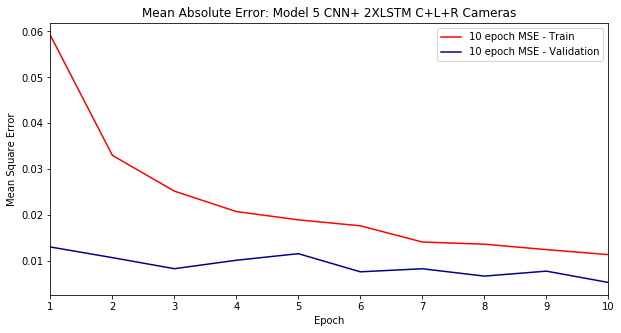

Root Mean Squared Error: 0.07307
Root Mean Squared Error: 0.09866


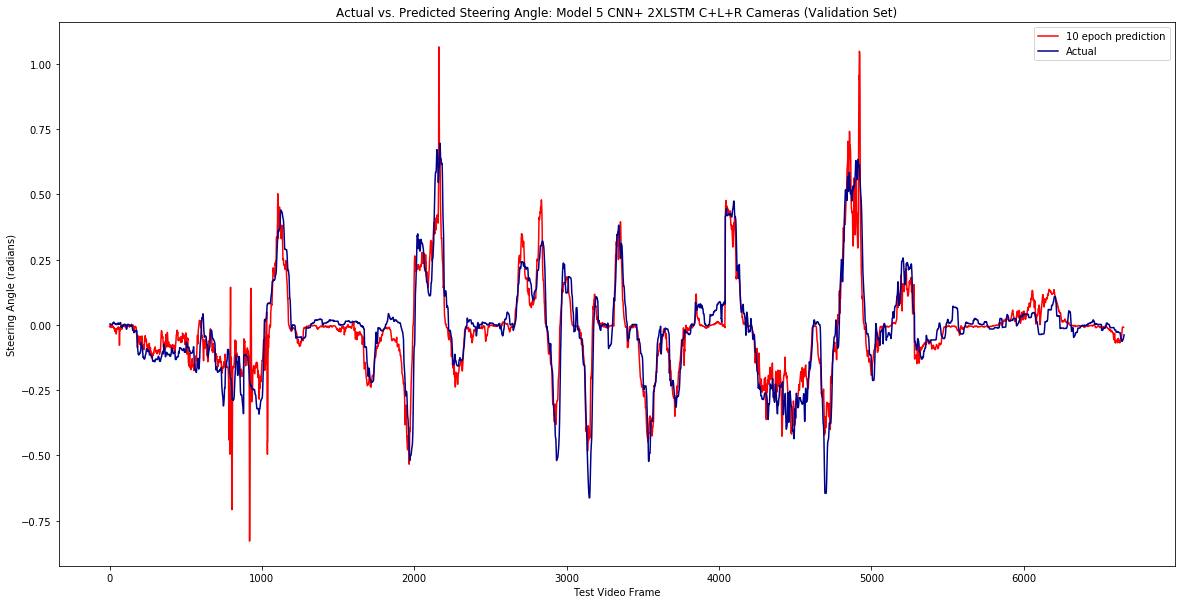

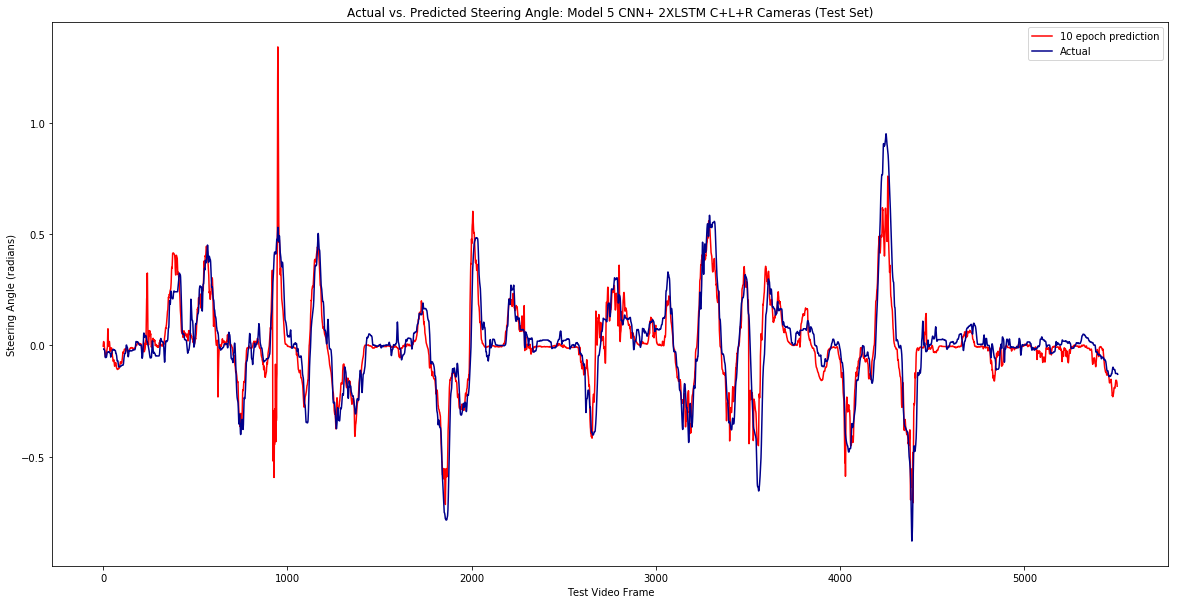

In [32]:
plt.figure(figsize = (10,5))
plt.title('Mean Absolute Error: Model 5 CNN+ 2XLSTM C+L+R Cameras')
plt.xlabel('Epoch')
plt.xlim(xmin=1)
dim=np.arange(1,11,1)
plt.plot(np.append(np.roll(train_mse_10,1),train_mse_10[len(train_mse_10)-1]), label = '10 epoch MSE - Train', c = 'red')
plt.plot(np.append(np.roll(val_mse_10,1),val_mse_10[len(val_mse_10)-1]), label = '10 epoch MSE - Validation', c = 'darkblue')
plt.xticks(dim)
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

#Score on the validation and test data

val_pred = m51e.predict(x_val, batch_size = 128)
test_pred = m51e.predict(x_test, batch_size = 128)

rmse(val_pred, y_val)
rmse(test_pred, y_test)

#Produce visualization for validation and test set predictions

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 5 CNN+ 2XLSTM C+L+R Cameras (Validation Set)')
plt.plot(val_pred, label = '10 epoch prediction', c = 'red')
plt.plot(y_val, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.title('Actual vs. Predicted Steering Angle: Model 5 CNN+ 2XLSTM C+L+R Cameras (Test Set)')
plt.plot(test_pred, label = '10 epoch prediction', c = 'red')
plt.plot(y_test, label = 'Actual', c = 'darkblue')
plt.xlabel('Test Video Frame')
plt.ylabel('Steering Angle (radians)')
plt.legend()
plt.show()

Here is a summary of the top performing model structure:

In [33]:
m51e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (128, 3, 58, 158, 32)     320       
_________________________________________________________________
time_distributed_28 (TimeDis (128, 3, 29, 79, 32)      0         
_________________________________________________________________
time_distributed_29 (TimeDis (128, 3, 29, 79, 32)      0         
_________________________________________________________________
time_distributed_30 (TimeDis (128, 3, 27, 77, 64)      18496     
_________________________________________________________________
time_distributed_31 (TimeDis (128, 3, 13, 38, 64)      0         
_________________________________________________________________
time_distributed_32 (TimeDis (128, 3, 13, 38, 64)      0         
_________________________________________________________________
time_distributed_33 (TimeDis (128, 3, 11, 36, 128)     73856     
__________

In [37]:
#Save final predictions for visualization purposes.
val_pred = m51e.predict(x_val, batch_size = 128)
test_pred = m51e.predict(x_test, batch_size = 128)

#Save final predictions
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\val_preds.npy', val_pred)
np.save(r'C:\Users\ryan13829\Desktop\Thinkful\test_preds.npy', test_pred)

# Future Work

Additional data augmentation - rotating images to simulate additional training data. Adding Left and Right camera images improved the model's performance, and rotations are a commonly used technique in this area. 

Removing color helped reduce the dimensionality of the dataset and thus improve training time - as well as allowing us to remain within the RAM limits of our virtual machine - but it did seem to hurt the model performance somewhat. In the future, I would like to explore other techniques that would allow me to maintain the 3 color channel representation of the dataset. Along the same lines, I was forced to trim the lookback / sequential training set to 3 images for the combined center + left + right image training set (down from 7 using just center camera data).

I also would like to be able to spend some more time tuning model hyperparameters and layer configurations. There are near infinite possibilities and while my model performs well in it's current state, I am certain that significant improvements could be made with small tweaks to model structure (optimizer, learning rate, number of layers, number of features in the layers, dropout, regularization, normalization, etc). 


# Resources used:
[1] https://github.com/rwightman/udacity-driving-reader

[2] http://cs231n.stanford.edu/reports/2017/pdfs/629.pdf

[3] http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html

[4] https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

[5] https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders

[6] http://cs231n.stanford.edu/reports/2017/pdfs/626.pdf

[7] https://github.com/commaai/research/blob/master/view_steering_model.py

[8] https://arxiv.org/pdf/1604.07316.pdf

# Competition rankings:

https://github.com/udacity/self-driving-car/tree/master/challenges/challenge-2

Based on this list, my best-performing model would rank in 8th place in the final standings!